# Instructions
---
This is the code for the paper _______________________.

First of all, run all the prerequisites. They are the installation and import of the needed packages, the definition of the functions and models of SNNs and several more details to make the code work. 

Then, if you want to run the benchmarks presented in the paper, run the _**Automated benchmark**_ section. Further instructions are presented in this section. For obtaining the figures of the paper of the Bayesian Analysis and CD Graph, a section is also provided after the benchmark.

For following the step-by-step process, the other sections are provided. First the In- and Out-of-Distribution datasets must be selected, as well as the model to test. In the section _**Spike Counts Pattern based Detector (SCPD)**_ all the code to execute the detector is available.

In the _**OoD detection benchmak**_ section, the results for the selected dataset and model for the other methods can be checked.

Finally, in _**Explainability**_ the heatmap generation code is provided.

# Prerequisites

In [1]:
#@title #Installation of Norse and imports
!pip install --quiet norse

# Install the libraries for the Bayesian tests and CD graph
!pip install --quiet Orange3 
!git clone https://github.com/BayesianTestsML/tutorial.git
import tutorial.Python.bayesiantests as bt

import os
from pathlib import Path
import logging
import sys
from collections import OrderedDict
import datetime
import pytz

import torch
import torchvision
from torchvision.datasets.vision import VisionDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm, trange

from norse.torch import ConstantCurrentLIFEncoder
from norse.torch import SpikeLatencyLIFEncoder
from norse.torch import PoissonEncoder
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

from google.colab import files

import ipywidgets as ipw
from IPython.core.display import HTML, display, clear_output
from ipywidgets import widgets,interact, interactive, fixed, interact_manual

from scipy import spatial
import scipy.special as scysp
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from skimage.transform import resize
from sklearn.utils import shuffle as skl_shuffle

fatal: destination path 'tutorial' already exists and is not an empty directory.


## Functions

In [7]:
#@markdown ##Constants

# Path for the datasets
root_path = Path(Path.cwd())
datasets_path = root_path / 'Datasets'
pretrained_weights_path = root_path / 'Pretrained_weights'
figures_path = root_path / 'Figures'

# Create the directories
datasets_path.mkdir(exist_ok=True)
pretrained_weights_path.mkdir(exist_ok=True)
figures_path.mkdir(exist_ok=True)


# Constants for the correct visualization of the .csv in Spanish configuration
CSV_SEPARATOR = ';'
CSV_DECIMAL = ','

# For the explainability part
WHICH_FPR = 80 

In [8]:
#@markdown ##Utils

def searchIndicesOfClass(searchedClass, labelsArray, n=0 ,posIni = 0):
  '''
  Function that outputs a list with all the indices of the searchedClass in the labelsList 
  If n is provided, only the first n coincidences are outputted
  If posIni is provided, the search starts by this position.
  searchedClass, n, posIni -> integer
  labelsArray -> array
  '''
  indices = []
  if n is 0:
    # Case of searching for all the array
    for index, labels in enumerate(labelsArray[posIni:]):
      if labels == searchedClass:
        indices.append(posIni+index)
  else: 
    # Case of searching only n number of indices
    i = 0
    for index, labels in enumerate(labelsArray[posIni:]):
      if i >= n: 
          break
      if labels == searchedClass:
        indices.append(posIni+index)
        i += 1
  return indices


def indices_of_every_class_for_subset(
    train_loader, n_samples_per_class, dataset_name, init_pos=0):
  n_classes = len(train_loader.dataset.classes)
  selected_indices_per_class = []
  for cl_index in range(n_classes):
    # The +1 is beacuse the targets transformation does not happen
    # when accesing the dataset object, only in the dataloader
    if dataset_name == 'Letters':
      cl_index = cl_index + 1
    indices = searchIndicesOfClass(
        cl_index, 
        train_loader.dataset.targets, 
        n=n_samples_per_class,
        posIni=init_pos)
    selected_indices_per_class += indices
  return selected_indices_per_class


def average_per_class_and_cluster(spikeFrencuencies, preds, 
                                  clusterizationPerClass, option='median', 
                                  n_samples=None):
  '''
  Function that receives the counts and the predictions of a subset and the 
  clusterization objects per class of that subset and outputs a list of arrays 
  with the mean or median hidden frecuency vector of each cluster of each class
  '''
  # For every class
  avgPerClass = []
  for class_index in range(len(train_data.classes)):
    # Calculation of the array of frecuencies that corresponds to a class
    if n_samples is None:
      indices = searchIndicesOfClass(class_index, preds)
    else:
      indices = searchIndicesOfClass(class_index,preds,n_samples)
    spikesFrecsOneClass = spikeFrencuencies[indices]
    # For every cluster of the class, compute the median
    avgPerCluster = []
    for cluster_index in np.unique(clusterizationPerClass[class_index].labels_):
      # We can compute the mean or the median of the neuron frecuencies for that cluster
      if option == 'median': 
        avgPerCluster.append(np.median(spikesFrecsOneClass[np.where(clusterizationPerClass[class_index].labels_ == cluster_index)[0]],axis=0))
      elif option == 'mean':
        avgPerCluster.append(np.mean(spikesFrecsOneClass[np.where(clusterizationPerClass[class_index].labels_ == cluster_index)[0]],axis=0))
    avgPerCluster = np.array(avgPerCluster)
    # Save all the cluster averages to the list of the classes
    avgPerClass.append(avgPerCluster)
  return avgPerClass


def distance_to_clusters_averages(spikeFrencuencies, predictions, avgPerClass):
  '''
  Function that computes the distance of the introduced array to the 
  cluster's averages of the predicted class
  Takes the frecuencies and the predictions of each sample of a subset (not ordered by class) and the averages of each cluster and class
  Outputs the distance of each sample for each class
  # TODO: Describe the dimensions of the inputs
  '''
  # Order array by predicted class
  spikeFrecuencies_per_class = []
  for class_index in range(len(train_data.classes)):
    spikeFrecuencies_per_class.append(spikeFrencuencies[searchIndicesOfClass(class_index,predictions)])
  # Compute the pairwise distances per predicted class
  distances_per_class = []
  closest_clusters_per_class = []
  for class_index, frecs_one_class in enumerate(spikeFrecuencies_per_class):
    if frecs_one_class.size == 0:
      distances_per_class.append([])
      closest_clusters_per_class.append([])
    else:
      parwiseDist = pairwise_distances(frecs_one_class, avgPerClass[class_index],metric='manhattan')
      distances_per_class.append(np.min(parwiseDist, axis=1))
      closest_clusters_per_class.append(np.argmin(parwiseDist, axis=1))
  return distances_per_class, closest_clusters_per_class


def parse_size_of_dataloader(dataloader_obj: torch.utils.data.DataLoader, batch_size):
  if len(dataloader_obj.dataset) > 10000:
    subset = torch.utils.data.Subset(dataloader_obj.dataset, [x for x in range(10000)])
    subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=False)
    return subset_loader


def isolate_or_remove_mnistc(df, option):
  if option == 'Isolate':
    df = df.loc[
      df['Out-Distribution'].apply(lambda x: x.split('/')[0]) == 'MNIST-C'
    ]
  
  elif option == 'Remove' :
    df = df.loc[
      df['Out-Distribution'].apply(lambda x: x.split('/')[0]) != 'MNIST-C'
    ]

  return df


def isolate_model(df, option):
  df = df.loc[df['Model'] == option]
  if df.size == 0:
    raise ValueError('Empty dataframe, probably wrong model name selected')

  return df

def print_created_clusters_per_class(clusters_per_class):
  print('')
  print('Created clusters:')
  print('-'*75)
  # Printing the cluster composition for each class
  for cl_ind, clusters_one_class in enumerate(clusters_per_class):
    unique, counts = np.unique(clusters_one_class.labels_, return_counts=True)
    print('Clase',train_data.classes[cl_ind].ljust(15),'\t',dict(zip(unique, counts)))
    print('-'*75)

In [9]:
#@markdown ##Cluster creation
def create_clusters(subset_train_loader_clusters, preds_train_clusters,
                    spk_count_train_clusters,
                    size=1000, distance_for_clustering=None, verbose=2):
  """
  Verbose = 0 -> No prints and plots neither loggin info
  verbose = 1 -> Returns loggin info only
  Verbose = 2 -> Prints and plots
  """
  # Select a distance threshold for each class
  if distance_for_clustering is None:
    distance_for_clustering = (800,3000)
  opt_dist_thr_per_class = []
  opt_silh_score_values_per_class = []
  dist_thrs          = np.linspace(distance_for_clustering[0], 
                                   distance_for_clustering[1],50)
  silhScoresPerClass = []
  clusterLabels = []

  n_classes = len(subset_train_loader_clusters.dataset.dataset.classes)
  for class_index in tqdm(range(n_classes), desc='Computing silhuette score for various distance thresholds'):
    dunnIndexes = []
    silh_scores = []
    for dist in dist_thrs:
      indices = searchIndicesOfClass(class_index, preds_train_clusters, size)
      cluster_model = AgglomerativeClustering(n_clusters=None,affinity='manhattan',linkage='average',distance_threshold=dist)
      try: # Handle the case that one class has no representation in the training samples
        cluster_model.fit(spk_count_train_clusters[indices])
        clusterLabels.append(cluster_model.labels_)
      except ValueError as e:
        print('Error probably caused by the lack of training samples for one specific class')
        raise(e)
      try:
        silh_scores.append(silhouette_score(spk_count_train_clusters[indices], cluster_model.labels_, metric='manhattan'))
      except ValueError:
        silh_scores.append(0)
    silhScoresPerClass.append(silh_scores)

    # Iterate the inverted to catch the smallest distance value with the 
    # greatest silhouette score
    max_score = 0
    max_index = 0
    for idx, current_score in enumerate(silh_scores):
      # Store the greatest value we encounter traveling the curve
      # Only update the value if it is greater, not if it equal
      if current_score > max_score: 
        max_index = idx
        max_score = current_score
    # We append the distance treshold to a list where they are going to be
    # stored, one for each class
    opt_dist_thr_per_class.append(dist_thrs[max_index])
    opt_silh_score_values_per_class.append(silh_scores[max_index])
  
  # Plot the silhouette score for every distance threshold
  if verbose == 2:
    # Plot to see the silhouette scores
    print('Selected distance thresholds:\n', opt_dist_thr_per_class)
    if n_classes == 10:
      fig, axes = plt.subplots(2,5,figsize=(6*n_classes/2, 12))
    elif n_classes == 26:
      fig, axes = plt.subplots(2,13,figsize=(6*n_classes/2, 12))
    else:
      raise NameError(f'The number of classes {n_classes} is not implemented for the plots')

    for class_index, ax in enumerate(axes.flat):
      ax.plot(dist_thrs,silhScoresPerClass[class_index], color='blue')
      ax.plot(opt_dist_thr_per_class[class_index], opt_silh_score_values_per_class[class_index], 'ro')
      ax.set_title(subset_train_loader_clusters.dataset.dataset.classes[class_index])
    plt.savefig('silhouetteScores.pdf')

  # Create the clusters by extracting the labels for every sample
  clusters_per_class = []
  for class_index in range(n_classes):
    indices = searchIndicesOfClass(class_index, preds_train_clusters, 1000)
    if isinstance(opt_dist_thr_per_class, list):
      cluster_model = AgglomerativeClustering(n_clusters=None,affinity='manhattan',linkage='complete',distance_threshold=opt_dist_thr_per_class[class_index])
    else:
      cluster_model = AgglomerativeClustering(n_clusters=None,affinity='manhattan',linkage='complete',distance_threshold=opt_dist_thr_per_class)
    
    cluster_model.fit(spk_count_train_clusters[indices])
    # Save the cluster models
    clusters_per_class.append(cluster_model)

  if verbose == 2:
    # Plot the top three levels of the dendrogram
    if n_classes == 10:
      fig, axes = plt.subplots(2,5,figsize=(6*n_classes/2, 12))
    elif n_classes == 26:
      fig, axes = plt.subplots(2,13,figsize=(6*n_classes/2, 12))
    else:
      raise NameError(f'The number of classes {n_classes} is not implemented for the plots')
    fig.suptitle('Hierarchical Clustering Dendrogram', fontsize=22, y=0.94)
    #fig.supxlabel('X axis: Number of points in node (index of the number if not in parenthesis)',fontsize = h + w*0.1,y=0.065)
  
    for class_index, ax in tqdm(enumerate(axes.flat), desc='Create the clusters with the selected distance thresholds'):
      plot_dendrogram(cluster_model, truncate_mode='level', p=3, ax=ax)
      ax.set_title('Class {}'.format(subset_train_loader_clusters.dataset.dataset.classes[class_index]),fontsize=22)
      #ax[i,j].set_xlabel("Number of points in node",fontsize=h)

    plt.savefig(f'DendrogramPerClass.pdf')
    fig.show()

    print_created_clusters_per_class(clusters_per_class)

  if verbose == 1:
    string_for_logger = 'Created clusters:\n' + '-'*75 + '\n'
    for class_index in range(len(train_data.classes)):
      unique, counts = np.unique(clusters_per_class[class_index].labels_, return_counts=True)
      string_for_logger += f'Clase {train_data.classes[class_index].ljust(15)} \t {dict(zip(unique, counts))}\n' + '-'*75 + '\n'

    return clusters_per_class, string_for_logger
  
  return clusters_per_class

In [10]:
#@markdown ##Plots
def plot_loss_history(training_losses, test_losses):
  fig = plt.figure(facecolor="w", figsize=(10, 5))
  plt.plot(training_losses)
  plt.plot(test_losses)
  plt.title("Loss Curves")
  plt.legend(["Train Loss", "Test Loss"])
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()


from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def plot_AUROC(fpr, tpr):
  # AUC
  auc = np.trapz(tpr, fpr)
  # Plot
  plt.figure(figsize=(15,12))
  roc = plt.plot(fpr,tpr,label='ROC curve', lw=3)
  rnd_roc = plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--', label='Random ROC curve')
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel('FPR',fontsize=20)
  plt.ylabel('TPR',fontsize=20)
  plt.title('ROC curve, AUC = %.3f'%auc,fontsize=25,pad=10)
  plt.fill_between(fpr, tpr, alpha=0.3)
  # Create empty plot with blank marker containing the extra label
  plt.plot([], [], ' ', label='FPR at 95% TPR = {}%'.format(round(fpr[95]*100,2)))
  plt.plot([], [], ' ', label='FPR at 80% TPR = {}%'.format(round(fpr[80]*100,2)))
  plt.legend(fontsize=20,loc='upper left')


def plot_AUPR(precision, tpr):
  # AUPR
  auc = np.trapz(precision, tpr)
  # Plot
  plt.figure(figsize=(15,12))
  roc = plt.plot(tpr, precision, label='ROC curve', lw=3)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel('FPR',fontsize=20)
  plt.ylabel('Precision',fontsize=20)
  plt.title('PR curve, AUC = %.3f'%auc,fontsize=25,pad=10)
  plt.fill_between(tpr, precision, alpha=0.3)
  plt.legend(fontsize=20,loc='upper left')


def plot_histogram(train, test, ood):
  fig = plt.figure(figsize=(10,5),tight_layout=True)
  plt.hist(train,bins=50,color='blue',alpha=0.6,density=True, label='Train')
  plt.hist(test,bins=50,color='green',alpha=0.6,density=True, label='Test')
  plt.hist(ood,bins=50,color='darkorange',alpha=0.6,density=True, label='ood')
  #plt.ylim([0,10])
  plt.legend(fontsize=18)
  plt.show()


def plot_ax(ax, img, plt_range, cmap, alpha=1, title=None, fontsize=8, xlabel=None):
  ax.set_xticks([])
  ax.set_yticks([])
  im = ax.imshow(img, vmin=plt_range[0],vmax=plt_range[1], cmap=cmap, alpha=alpha)
  if title is not None:
    ax.set_title(title, fontsize=fontsize)
  if xlabel is not None:
    ax.set_xlabel(xlabel, fontsize=fontsize)
  return im

In [11]:
#@markdown ##Metrics

### Common for all approaches ###
def tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr):
  '''
  Function that creates an array with the number of values of tp and fp or fn and tn, depending on if the 
  passed array is InD or OD.
  :in_or_out_distribution_per_tpr: array with True if predicted InD and False if predicted OD, for each TPR
  ::return: array with shape (tpr, 2) with the 2 dimensions being tp,fn if passed array is InD, and fp and tn if the passed array is OD
  '''
  tp_fn_fp_tn = np.zeros((len(in_or_out_distribution_per_tpr),2),dtype='uint16')
  length_array = in_or_out_distribution_per_tpr.shape[1]
  for index, element in enumerate(in_or_out_distribution_per_tpr):
    n_True = int(len(element.nonzero()[0]))
    tp_fn_fp_tn[index,0] = n_True
    tp_fn_fp_tn[index,1] = length_array - n_True
  return tp_fn_fp_tn

### Metrics for Distances per class approach ###

def thresholds_per_class_for_each_TPR(dist_per_class):
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  sorted_distances_per_class = [np.sort(x) for x in dist_per_class]
  tpr_range = np.arange(0,1,0.01)
  tpr_range[-1] = 0.99999999 # For selecting the last item correctly
  distance_thresholds_test = np.zeros((len(train_data.classes), len(tpr_range)))
  for class_index in range(len(train_data.classes)):
    for index, tpr in enumerate(tpr_range):
      distance_thresholds_test[class_index, index] = sorted_distances_per_class[class_index][int(len(sorted_distances_per_class[class_index])*tpr)]
  return distance_thresholds_test

def compare_distances_per_class_to_distance_thr_per_class(distances_list_per_class, thr_distances_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_list_per_class, and cotains True if its InD and False if is OD
  :distances_list_per_class: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array of shape (class, dist_for_each_tpr), where first dimension is the class and the second is the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(np.transpose(thr_distances_array)),len(np.concatenate(distances_list_per_class))),dtype=bool)
  for tpr_index ,thr_distances_per_class in enumerate(np.transpose(thr_distances_array)):
      in_or_out_distribution_per_tpr[tpr_index] = np.concatenate([dist_one_class < thr_distances_per_class[cls_index] for cls_index, dist_one_class in enumerate(distances_list_per_class)])
    
  return in_or_out_distribution_per_tpr

def compute_precision_tpr_fpr_for_test_and_ood(dist_test_per_class, dist_ood_per_class,dist_thresholds):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_distances_per_class_to_distance_thr_per_class(dist_test_per_class, dist_thresholds)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that one element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_ood = compare_distances_per_class_to_distance_thr_per_class(dist_ood_per_class, dist_thresholds)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_ood = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_ood)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_ood[:,0] / (fp_tn_ood[:,0] + fp_tn_ood[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_ood[:,0])

  # Eliminating NaN value at TPR = 1
  precision[0] = 1
  return precision, tpr_values, fpr_values


### Metrics for Distances all classes at the same time approach ###

def thresholds_for_each_TPR_distances(distance):
  """
  Creation of the array with the thresholds for each TPR
  """
  sorted_distance = np.sort(distance)
  # Inverse the order to get it correctly (greater the threshold, lower the TPR)
  tpr_range = np.arange(0,1,0.01)
  tpr_range[0] = 0.99999999 # For selecting the first item correctly
  distance_thresholds = np.zeros(len(tpr_range))
  for index, tpr in enumerate(tpr_range):
    distance_thresholds[index] = sorted_distance[int(len(sorted_distance)*tpr)]
  return distance_thresholds

def compare_distances_to_distance_thr_one_for_all_classes(distances_evaluating, thr_distances_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_evaluating, and cotains True if its InD and False if is ood
  :distances_evaluating: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array containing the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(thr_distances_array), len(distances_evaluating)), dtype=bool)
  for tpr_index, thr_for_one_tpr in enumerate(thr_distances_array):
      in_or_out_distribution_per_tpr[tpr_index] = np.where(distances_evaluating < thr_for_one_tpr, True, False)

  return in_or_out_distribution_per_tpr

def distance_method_compute_precision_tpr_fpr_for_test_and_ood(dist_test, dist_ood, dist_thresholds):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_distances_to_distance_thr_one_for_all_classes(dist_test, dist_thresholds)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that one element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_ood = compare_distances_to_distance_thr_one_for_all_classes(dist_ood, dist_thresholds)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_ood = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_ood)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_ood[:,0] / (fp_tn_ood[:,0] + fp_tn_ood[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_ood[:,0])

  # Eliminating NaN value at TPR = 1
  precision[0] = 1
  return precision, tpr_values, fpr_values


### Metrics for Likelihood all classes at the same time approach ###

def thresholds_for_each_TPR_likelihood(likelihood):
  """
  Creation of the array with the thresholds for each TPR
  """
  sorted_likelihood = np.sort(likelihood)
  # Inverse the order to get it correctly (greater the threshold, lower the TPR)
  tpr_range = np.arange(0,1,0.01)[::-1]
  tpr_range[0] = 0.99999999 # For selecting the first item correctly
  likelihood_thresholds = np.zeros(len(tpr_range))
  for index, tpr in enumerate(tpr_range):
    likelihood_thresholds[index] = sorted_likelihood[int(len(sorted_likelihood)*tpr)]
  return likelihood_thresholds

def compare_likelihood_to_likelihood_thr_one_for_all_classes(distances_evaluating, thr_distances_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_evaluating, and cotains True if its InD and False if is ood
  :distances_evaluating: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array containing the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(thr_distances_array), len(distances_evaluating)), dtype=bool)
  for tpr_index, thr_for_one_tpr in enumerate(thr_distances_array):
      in_or_out_distribution_per_tpr[tpr_index] = np.where(distances_evaluating > thr_for_one_tpr, True, False)

  return in_or_out_distribution_per_tpr

def likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(likelihood_test, likelihood_ood, likelihood_thresholds):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_likelihood_to_likelihood_thr_one_for_all_classes(likelihood_test, likelihood_thresholds)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that one element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_ood = compare_likelihood_to_likelihood_thr_one_for_all_classes(likelihood_ood, likelihood_thresholds)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_ood = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_ood)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_ood[:,0] / (fp_tn_ood[:,0] + fp_tn_ood[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_ood[:,0])

  # Eliminating NaN value at TPR = 1 and other NaN values that may appear due to
  # precision = TP / (TP + FN) = 0 / (0 + 0)
  #precision[0] = 1
  np.nan_to_num(precision, nan=1, copy=False)
  return precision, tpr_values, fpr_values


### Metrics for Likelihood per class approach ###

def thresholds_likelihood_per_class_for_each_TPR(likelihood_per_class):
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  sorted_distances_per_class = [np.sort(x) for x in likelihood_per_class]
  tpr_range = np.arange(0,1,0.01)
  tpr_range[-1] = 0.99999999 # For selecting the last item correctly
  distance_thresholds_test = np.zeros((len(train_data.classes), len(tpr_range)))
  for class_index in range(len(train_data.classes)):
    for index, tpr in enumerate(tpr_range[::-1]):
      distance_thresholds_test[class_index, index] = sorted_distances_per_class[class_index][int(len(sorted_distances_per_class[class_index])*tpr)]
  return distance_thresholds_test

def compare_likelihood_per_class_to_likelihood_thr_per_class(likelihood_list_per_class, thr_likelihood_array):
  '''
  Function that creates an array of shape (tpr, InD_or_OD), where tpr has the lenght of the number of steps of the TPR list
  and second dimensions has the total lenght of the distances_list_per_class, and cotains True if its InD and False if is OD
  :distances_list_per_class: list with each element being an array with the distances to avg clusters of one class [array(.), array(.)]
  :thr_distances_array: array of shape (class, dist_for_each_tpr), where first dimension is the class and the second is the distance for the TPR
   corresponding to that position. For example, the TPR = 0.85 corresponds to the 85th position.
  '''
  in_or_out_distribution_per_tpr = np.zeros((len(np.transpose(thr_likelihood_array)),len(np.concatenate(likelihood_list_per_class))),dtype=bool)
  for tpr_index ,thr_likelihood_per_class in enumerate(np.transpose(thr_likelihood_array)):
      in_or_out_distribution_per_tpr[tpr_index] = np.concatenate([likelihood_one_class > thr_likelihood_per_class[cls_index] for cls_index, likelihood_one_class in enumerate(likelihood_list_per_class)])
    
  return in_or_out_distribution_per_tpr

def likelihood_method_per_class_compute_precision_tpr_fpr_for_test_and_ood(likelihood_test_per_class, likelihood_ood_per_class, likelihood_thresholds_per_class):
  # Creation of the array with True if predicted InD (True) or OD (False)
  in_or_out_distribution_per_tpr_test = compare_likelihood_per_class_to_likelihood_thr_per_class(likelihood_test_per_class, likelihood_thresholds_per_class)
  in_or_out_distribution_per_tpr_test[0] = np.zeros((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that one element is True when TPR is 0
  in_or_out_distribution_per_tpr_test[-1] = np.ones((in_or_out_distribution_per_tpr_test.shape[1]),dtype=bool) # To fix that last element is True when TPR is 1
  in_or_out_distribution_per_tpr_ood = compare_likelihood_per_class_to_likelihood_thr_per_class(likelihood_ood_per_class, likelihood_thresholds_per_class)

  # Creation of arrays with TP, FN and FP, TN
  tp_fn_test = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_test)
  fp_tn_ood = tp_fn_fp_tn_computation(in_or_out_distribution_per_tpr_ood)

  # Computing TPR, FPR and Precision
  tpr_values = tp_fn_test[:,0] / (tp_fn_test[:,0] + tp_fn_test[:,1])
  fpr_values = fp_tn_ood[:,0] / (fp_tn_ood[:,0] + fp_tn_ood[:,1])
  precision  = tp_fn_test[:,0] / (tp_fn_test[:,0] + fp_tn_ood[:,0])

  # Eliminating NaN value at TPR = 1
  precision[0] = 1
  return precision, tpr_values, fpr_values

In [12]:
#@markdown ##Explainability
def order_array_of_samples_to_per_class_list(array, preds, n_samples=0):
  list_per_class = []
  for cl_index in range(len(train_data.classes)):
    indices = searchIndicesOfClass(cl_index, preds, n_samples)
    list_per_class.append(array[indices])
  return list_per_class

def compute_reconstruction(spk_counts, weights):
  if isinstance(weights, list):
    for l, w_l in enumerate(weights):
      if l == 0:
        reconst = np.matmul(spk_counts, w_l)
      else:
        reconst = np.matmul(reconst, w_l)
  else:
    reconst = np.matmul(spk_counts, weights)
  return reconst


def compute_reconstruction_per_class(spikeFrec_per_class, weights):
  reconst_per_class = []
  for spikes_one_class in spikeFrec_per_class:
    reconst = compute_reconstruction_n_layers(spikes_one_class, weights)
    reconst_per_class.append(reconst)
  return reconst_per_class


def compute_reconstruction_n_layers(spk_counts, weights):
  if isinstance(weights, list):
    for l, w_l in enumerate(weights):
      if l == 0:
        reconst = np.matmul(spk_counts, w_l)
      else:
        reconst = np.matmul(reconst, w_l)
  else:
    reconst = np.matmul(spk_counts, weights)

  return reconst


def extract_positive_part_per_class(list_per_class):
  positive_part_list = []
  for array_one_class in list_per_class:
    positive_part_list.append(np.where(array_one_class > 0, array_one_class, 0))
  return positive_part_list


def rearrange_to_ftmaps(spk_count, ftmaps_shape=(50, 8, 8)):
  ch, h, w = ftmaps_shape
  unflatten = torch.nn.Unflatten(-1, (ch, h, w))
  return unflatten(torch.from_numpy(spk_count)).numpy()


def rearrange_to_ftmaps_per_class(spk_count_per_class, ftmaps_shape=(50, 8, 8)):
  ftmaps_per_class = []
  for spk_one_class in spk_count_per_class:
    ftmaps_per_class.append(rearrange_to_ftmaps(spk_one_class, ftmaps_shape))
  return ftmaps_per_class

def auroc_aupr(d_train_per_class, d_test_per_class, d_ood_per_class):
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  d_thresholds_train = thresholds_per_class_for_each_TPR(d_train_per_class)
  # Conmputing precision, tpr and fpr
  precision, tpr_values, fpr_values = compute_precision_tpr_fpr_for_test_and_ood(d_test_per_class, d_ood_per_class, d_thresholds_train)
  # Appending that when FPR = 1 the TPR is also 1:
  tpr_val_auroc = np.append(tpr_values,1)
  fpr_val_auroc = np.append(fpr_values,1)

  #AUROC
  auroc = np.trapz(tpr_val_auroc, fpr_val_auroc)

  # AUPR
  aupr = np.trapz(precision, tpr_values)

  print('-'*30)
  print(f'Results')
  print('-'*30)
  print(f'AUROC = {auroc*100:.3f} %')
  print(f'AUPR  = {aupr*100:.3f} %')
  print('-'*30)
  print(f'FPR at 95% TPR: {round(fpr_val_auroc[95]*100,2)}%')
  print(f'Threshold mean and std for all classes at 95% TPR: {d_thresholds_train[:, 95].mean():.2f}, {d_thresholds_train[:, 95].std():.2f}')
  print('-'*30,'\n')

  return d_thresholds_train


def create_spk_count(model, device, ood_dict, od_dataset, mnist_c_opt='zigzag', conv_spikes=False):
  if od_dataset == 'MNIST-C':
    test_loader_ood = ood_dict[od_dataset](
        BATCH_SIZE,
        test_only=True,
        option=mnist_c_opt
        )
  else:
    test_loader_ood = ood_dict[od_dataset](BATCH_SIZE, test_only=True)
    
  # Extract logits and hidden spikes
  if selected_model == 'ConvNet':
    if conv_spikes is True:
      accuracy_ood, preds_ood, logits_ood, _spk_count_ood, _conv_spk_ood = test(model, device, test_loader_ood, return_logits=True, return_conv_spikes=True)
      print(f'Accuracy for the ood dataset {od_dataset} is {accuracy_ood:.3f} %')
      return test_loader_ood, preds_ood, np.sum(_spk_count_ood,axis=0, dtype='uint16'), np.sum(_conv_spk_ood, axis=0, dtype='uint16')
    else:
      accuracy_ood, preds_ood, logits_ood, _spk_count_ood = test(model, device, test_loader_ood, return_logits=True, return_conv_spikes=False)
  else:
    accuracy_ood, preds_ood, logits_ood, _spk_count_ood = test(model, device, test_loader_ood, return_logits=True, return_conv_spikes=False)
  print(f'Accuracy for the ood dataset {od_dataset} is {accuracy_ood:.3f} %')

  return test_loader_ood, preds_ood, np.sum(_spk_count_ood,axis=0, dtype='uint16')

## Datasets loading

### MNIST


In [8]:
def load_MNIST(batch_size, test_only=False):
  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor(),
      ]
  )
  test_data_MNIST = torchvision.datasets.MNIST(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_MNIST = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(
          root=datasets_path,
          train=False,
          transform=transform,
      ),
      batch_size=batch_size
  )
  if test_only is False:
    train_data_MNIST = torchvision.datasets.MNIST(
        root=datasets_path,
        train=True,
        download=True,
        transform=transform,
    )
    train_loader_MNIST = torch.utils.data.DataLoader(
        train_data_MNIST,
        batch_size=batch_size,
        shuffle=True
    )
    return train_data_MNIST, train_loader_MNIST, test_loader_MNIST
  else:
    return test_loader_MNIST

### Fashion MNIST

In [9]:
def load_Fashion_MNIST(batch_size, test_only=False):
  transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
  )
  test_data_fashion_MNIST = torchvision.datasets.FashionMNIST(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_fashion_MNIST = torch.utils.data.DataLoader(
      test_data_fashion_MNIST,
      batch_size=batch_size
  )

  if test_only is False:
    train_data_fashion_MNIST = torchvision.datasets.FashionMNIST(
        root=datasets_path,
        train=True,
        download=True,
        transform=transform,
    )
    train_loader_fashion_MNIST = torch.utils.data.DataLoader(
        train_data_fashion_MNIST,
        batch_size=batch_size,
        shuffle=True
    )
    return train_data_fashion_MNIST, train_loader_fashion_MNIST, test_loader_fashion_MNIST
  else:
    return test_loader_fashion_MNIST

### KMNIST

In [10]:
def load_KMNIST(batch_size, test_only=False):
  BATCH_SIZE = 256

  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor(),
      ]
  )

  test_data_KMNIST = torchvision.datasets.KMNIST(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_KMNIST = torch.utils.data.DataLoader(
      torchvision.datasets.KMNIST(
          root=datasets_path,
          train=False,
          transform=transform,
      ),
      batch_size=batch_size
  )
  if test_only is False:
    train_data_KMNIST = torchvision.datasets.KMNIST(
        root=datasets_path,
        train=True,
        download=True,
        transform=transform,
    )

    train_loader_KMNIST = torch.utils.data.DataLoader(
        train_data_KMNIST,
        batch_size=batch_size,
        shuffle=True
    )
    return train_data_KMNIST, train_loader_KMNIST, test_loader_KMNIST
  else:
    return test_loader_KMNIST

### MNIST with a square added

In [11]:
import random
def square_creation(input_tensor: torch.Tensor):
  posible_values = [2,20]
  mean = int(torch.mean(input_tensor[0])*100)
  random.seed(mean)
  x_rnd = random.randint(0, 1)
  x_start = posible_values[x_rnd]
  random.seed(mean-1)
  y_rnd = random.randint(0, 1)
  y_start = posible_values[y_rnd]
  input_tensor[:, x_start:x_start+6, y_start:y_start+6] = torch.ones((1,6,6), dtype=torch.float32)
  return input_tensor

def load_MNIST_square(batch_size, test_only=True, *args):
  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Lambda(square_creation)
      ]
  )
  test_data_MNIST_square = torchvision.datasets.MNIST(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_MNIST_square = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(
          root=datasets_path,
          train=False,
          transform=transform,
      ),
      batch_size=batch_size
  )
  return test_loader_MNIST_square

### Cifar10-BW

In [12]:
def load_CIFAR10_BW(batch_size, test_only=True):
  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Grayscale(num_output_channels=1),
          torchvision.transforms.Resize((28,28))
      ]
  )

  test_data_CIFAR10 = torchvision.datasets.CIFAR10(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_CIFAR10 = torch.utils.data.DataLoader(
      test_data_CIFAR10,
      batch_size=batch_size,
      shuffle=False
  )
  return test_loader_CIFAR10

### Cifar10 colored

In [13]:
def load_CIFAR10(batch_size, test_only=False):
  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor()
      ]
  )
  test_data_CIFAR10 = torchvision.datasets.CIFAR10(
      root=datasets_path,
      train=False,
      download=True,
      transform=transform,
  )
  test_loader_CIFAR10 = torch.utils.data.DataLoader(
      test_data_CIFAR10,
      batch_size=batch_size,
      shuffle=False
  )

  if test_only is False:
    train_data_CIFAR10 = torchvision.datasets.CIFAR10(
        root=datasets_path,
        train=True,
        download=True,
        transform=transform,
    )

    train_loader_CIFAR10 = torch.utils.data.DataLoader(
        train_data_CIFAR10,
        batch_size=batch_size,
        shuffle=True
    )
    return train_data_CIFAR10, train_loader_CIFAR10, test_loader_CIFAR10

  else:
    return test_loader_CIFAR10

### Letters

In [14]:
from torchvision.transforms import Lambda
def load_MNIST_Letters(batch_size, test_only=False):
  # The rotation and horizontal flip are for getting the images in a similar 
  # way to the MNIST dataset i.e. vertical and readable from left to right
  transform = torchvision.transforms.Compose(
      [
          lambda img: torchvision.transforms.functional.rotate(img, -90),
          lambda img: torchvision.transforms.functional.hflip(img),
          torchvision.transforms.ToTensor(),
      ]
  )
  test_data_letters = torchvision.datasets.EMNIST(
      root=datasets_path,
      split= "letters",
      train=False,
      download=True,
      transform=transform,
      target_transform=Lambda(
          lambda y: y-1
      ),
  )
  # Eliminate the first class, that is non-existant for our case
  test_data_letters.classes = test_data_letters.classes[1:] 
  test_loader_letters = torch.utils.data.DataLoader(
      test_data_letters,
      batch_size=batch_size,
      shuffle=False
  )
  # To obtain 10.000 test samples, pass trought the function
  #test_loader_letters = parse_size_of_dataloader(test_loader_letters, batch_size)
  if test_only is False:
    train_data_letters = torchvision.datasets.EMNIST(
        root=datasets_path,
        split= "letters",
        train=True,
        download=True,
        transform=transform,
        target_transform=Lambda(
          lambda y: y-1
      ),
    )
    train_data_letters.classes = train_data_letters.classes[1:] 
    train_loader_letters = torch.utils.data.DataLoader(
        train_data_letters,
        batch_size=batch_size,
        shuffle=True
    )

    return train_data_letters, train_loader_letters, test_loader_letters
  else:
    return test_loader_letters

### Omniglot

In [15]:
def load_omniglot(batch_size, test_only=True):
  transform = torchvision.transforms.Compose(
      [
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Resize((28,28)),
          Lambda( lambda img: torchvision.transforms.functional.invert(img)),
      ]
  )
  test_data = torchvision.datasets.Omniglot(
      root=datasets_path,
      background=False,
      download=True,
      transform=transform,
  )
  test_loader = torch.utils.data.DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False
  )
  test_loader = parse_size_of_dataloader(test_loader, batch_size)
  return test_loader

### notMNIST

In [16]:
class notMNIST(VisionDataset):
    def __init__(self, root: Path, transform=None, samples_per_class=None):
        """
        Args:
            root (string): Directory with the images of the selected option.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        classes = []
        images = []
        targets = []
        # Every directory is a class in the structure of notMNINST
        for cl_index, class_dir_name in enumerate(sorted(root.iterdir())): 
          # Extract the class name from the path
          classes.append(class_dir_name.as_posix().split('/')[-1])
          class_dir_path = root / class_dir_name
          if samples_per_class is None:
            # We put the limit way above the length of the dataset to not limit
            # the data collected at all, as None indicates that we want all the 
            # data available
            limit = 1000000
          else:
            limit = samples_per_class
          for index, png_im in enumerate(sorted(class_dir_path.iterdir())):
            if index == limit:
              break
            else:
              # Some images are corrupted, so we skip those images
              try:
                # Get images in range 0-1
                images.append(torchvision.io.read_image(png_im.as_posix())/255)
                targets.append(cl_index)
              except RuntimeError:
                # we have to update the limit to obtain the desired
                # number of imgs per class
                limit += 1
                continue

        # Transform list to tensors
        images = torch.stack(images, dim=0)
        targets = torch.tensor(targets, dtype=torch.uint8)
  
        '''
        images = torch.zeros(10*samples_per_class, 1, 28, 28, 
                             dtype=torch.float32)
        labels = torch.zeros(10*samples_per_class, dtype=torch.uint8)
        # Every directory is a class in the structure of notMNINST
        for cl_index, class_dir_name in enumerate(sorted(root.iterdir())): 
          # Extract the class name from the path
          classes.append(class_dir_name.as_posix().split('/')[-1])
          class_dir_path = root / class_dir_name
          labels[cl_index*samples_per_class:(cl_index+1)*samples_per_class] = torch.ones(samples_per_class, dtype=torch.uint8)*cl_index
          limit = samples_per_class
          for index, png_im in enumerate(sorted(class_dir_path.iterdir())):
            if index == limit:
              break
            else:
              # Some images are corrupted, so we skip those images
              try:
                # Get images in range 0-1
                images[samples_per_class*cl_index + index] = torchvision.io.read_image(png_im.as_posix())/255
              except RuntimeError:
                # we have to update the limit to obtain the desired
                # number of imgs per class
                limit += 1
                continue
        '''
        # Shuffle fixed for reproducibility reasons
        self.images, self.targets = skl_shuffle(images, targets,
                                                         random_state=7)
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.images[idx], self.targets[idx]]
        if self.transform:
            sample = self.transform(sample)
        return sample

def load_notMNIST(batch_size, test_only=True, samples_per_class=1000):
  # Test only for compatibility issues
  notmnist_path = datasets_path / 'notMNIST_small'
  if not notmnist_path.exists():
    !wget -O notMNIST.tar.gz --no-check-certificate "https://tecnalia365-my.sharepoint.com/:u:/g/personal/aitor_martinez_tecnalia_com/EZTrDELAyABNqHplnGnNaqgBTCiHIPBAW5D-DBsAmBIGcw?download=1"
    !tar -zxf notMNIST.tar.gz -C $datasets_path
    !rm notMNIST.tar.gz

  loader = torch.utils.data.DataLoader(
      notMNIST(notmnist_path, samples_per_class=samples_per_class), 
      batch_size=256,
      shuffle=False
      )
  return loader

### MNIST-C

In [17]:
class MNIST_C(VisionDataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with the images of the selected option.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = Path(root_dir)
        self.images = np.load(self.root / 'test_images.npy')
        self.targets = np.load(self.root / 'test_labels.npy').astype('uint8')
        self.transform = transform
        self.classes = [str(x) for x in range(10)]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.images[idx], self.targets[idx]]
        if self.transform:
            sample = self.transform(sample)
        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))/255
        return [torch.from_numpy(image), torch.tensor(label)]


def load_MNIST_C(batch_size, test_only=True, option='zigzag'):
  if not (datasets_path / 'mnist_c').exists():
    !wget -O mnist_c.gz --no-check-certificate "https://tecnalia365-my.sharepoint.com/:u:/g/personal/aitor_martinez_tecnalia_com/ERi3c4DxluJFqpv4wtlTkKEBvhdrY4WwqNRJWKyyVoTQqg?download=1"
    !unzip mnist_c.gz -d $datasets_path
    !rm mnist_c.gz
 
  mnist_c_loader = torch.utils.data.DataLoader(
      MNIST_C(datasets_path / 'mnist_c' / option, ToTensor()), 
      batch_size=256,
      shuffle=False
      )
  return mnist_c_loader

## Model definition (encoder, hidden layers and decoder)

In [18]:
#@markdown ##Model class
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x, flag=None):
        x = self.encoder(x)
        if flag is None:
          x = self.snn(x)
          x = self.decoder(x)
          return x

        elif flag == "hidden_spikes_and_logits":
          x, hdd_spks = self.snn(x, flag)
          x, _ = torch.max(x, 0) 
          return x, hdd_spks

        elif flag == "hidden_and_conv_spikes_and_logits":
          x, hdd_spks, conv_spks = self.snn(x, flag)
          x, _ = torch.max(x, 0) 
          return x, hdd_spks, conv_spks

In [19]:
#@markdown ##Decoding function
def decode(x):
  # First take the max across all time steps, the first dimension
  # [time_step, batch_size, output_neurons ]
  x, _ = torch.max(x, 0)
  # Then compute the logsoftmax across the 
  log_p_y = torch.nn.functional.log_softmax(x, dim=1)
  return log_p_y

### Fully Connected models

In [20]:
#@markdown ## Fully connected model class
from norse.torch import LIFParameters
from norse.torch.module.lif import LIFCell
from norse.torch import LICell

MODEL_NAME = 'Fully connected'
class FC_SNN_1(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, dt=0.001):
        #super(FC_SNN_1, self).__init__()
        super().__init__()

        # Hidden layer
        self.fc1 = torch.nn.Linear(input_features, hidden_features, bias=False)
        self.lif1 = LIFCell(
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt            
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_neurons = output_features
      
    def forward(self, x, flag=None):
        # Input shape = [time_step,batch_size, ... , ... , ... ]
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        #voltages = []

        voltages = torch.zeros(
            seq_length, batch_size, self.output_neurons,
            device=x.device, dtype=x.dtype
        )
        if flag is None:
          for ts in range(seq_length):
              # Flatten the input to [batch_size, input_features]
              z = x[ts, :, :, :].view(-1, self.input_features)
              
              # Hidden layer
              z = self.fc1(z)
              z, s1 = self.lif1(z, s1)

              # Output layer
              z = self.fc_out(z)
              vo, so = self.out(z, so)
              voltages[ts] = vo

          return voltages

        elif flag == "hidden_spikes_and_logits":
          hdn_spikes = torch.zeros(
              seq_length, batch_size, self.hidden_features,
              device=x.device, dtype=x.dtype
          )
          for ts in range(seq_length):
              # Flatten the input to [batch_size, input_features]
              z = x[ts, :, :, :].view(-1, self.input_features)
              
              # Hidden layer
              z = self.fc1(z)
              z, s1 = self.lif1(z, s1)
              hdn_spikes[ts] = z

              # Output layer
              z = self.fc_out(z)
              vo, so = self.out(z, so)
              voltages[ts] = vo
        else:
          raise NameError('Wrong flag')

        return voltages, hdn_spikes
        

In [21]:
#@markdown ## Fully connected model class 2 hidden layers
from norse.torch import LIFParameters
from norse.torch.module.lif import LIFCell
from norse.torch import LICell

MODEL_NAME = 'Fully connected'
class FC_SNN_2(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, dt=0.001):
        #super(FC_SNN_2, self).__init__()
        super().__init__()

        # Hidden layer
        self.fc1 = torch.nn.Linear(input_features, 300, bias=False)
        self.fc2 = torch.nn.Linear(300, hidden_features, bias=False)
        self.lif1 = LIFCell(
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.25)),
            dt=dt            
        )
        self.lif2 = LIFCell(
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.25)),
            dt=dt            
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_neurons = output_features
      
    def forward(self, x, flag=None):
        # Input shape = [time_step,batch_size, ... , ... , ... ]
        seq_length, batch_size, _, _, _ = x.shape
        s1 = s2 = so = None
        #voltages = []

        voltages = torch.zeros(
            seq_length, batch_size, self.output_neurons,
            device=x.device, dtype=x.dtype
        )
        if flag is None:
          for ts in range(seq_length):
              # Flatten the input to [batch_size, input_features]
              z = x[ts, :, :, :].view(-1, self.input_features)
              
              # Hidden layer 1
              z = self.fc1(z)
              z, s1 = self.lif1(z, s1)

              # Hidden layer 2
              z = self.fc2(z)
              z, s2 = self.lif2(z, s2)

              # Output layer
              z = self.fc_out(z)
              vo, so = self.out(z, so)
              voltages[ts] = vo

          return voltages

        elif flag == "hidden_spikes_and_logits":
          hdn_spikes = torch.zeros(
              seq_length, batch_size, self.hidden_features,
              device=x.device, dtype=x.dtype
          )
          for ts in range(seq_length):
              # Flatten the input to [batch_size, input_features]
              z = x[ts, :, :, :].view(-1, self.input_features)
              
              # Hidden layer 1
              z = self.fc1(z)
              z, s1 = self.lif1(z, s1)
              #hdn_spikes[ts] = z

              # Hidden layer 2
              z = self.fc2(z)
              z, s2 = self.lif2(z, s2)
              hdn_spikes[ts] = z

              # Output layer
              z = self.fc_out(z)
              vo, so = self.out(z, so)
              voltages[ts] = vo
        else:
          raise NameError('Wrong flag')

        return voltages, hdn_spikes

### Convolutional Networks

In [22]:
#@markdown SNN - ConvNet - (20, 3x3) -> (50, 3x3) - AVG POOL
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

class ConvNet_1(torch.nn.Module):
    def __init__(self, hidden_neurons, output_neurons, num_channels=1, 
        feature_size=28, alpha=100):
        #super(ConvNet, self).__init__()
        super().__init__()

        self.features = int(((feature_size - 2) / 2) - 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 3, 1, bias=False)
        self.conv2 = torch.nn.Conv2d(20, 50, 3, 1, bias=False)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, hidden_neurons, bias=False)
        self.fc2 = torch.nn.Linear(hidden_neurons, output_neurons, bias=False) # Out fc
        self.lif0 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.2), alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.2), alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.1), alpha=alpha))
        self.out = LICell()

        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons

    def forward(self, x, flag=None):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = so = None
        voltages = torch.zeros(
            seq_length, batch_size, self.output_neurons, device=x.device, dtype=x.dtype
        )
        if flag is None:
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) 
              z, s0 = self.lif0(z, s0) 
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z)
              z, s1 = self.lif1(z, s1)
              #z = torch.nn.functional.avg_pool2d(z, 2)
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function

              # Second linear connection
              z = self.fc2(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages

        elif flag == "hidden_spikes_and_logits":
          hdn_spk_last_layer = torch.zeros(
              seq_length, batch_size, self.hidden_neurons, device=x.device, dtype=torch.int8
          )
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) # (batch_size, filters (20), H-2, W-2)
              z, s0 = self.lif0(z, s0) # (batch_size, filters (20), H-2, W-2)
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z) # Multiplica por 10 para que el valor de 
              z, s1 = self.lif1(z, s1)              
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function
              hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fc2(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages, hdn_spk_last_layer

        
        elif flag == "hidden_and_conv_spikes_and_logits":
          hdn_spk_last_layer = torch.zeros(
              seq_length, batch_size, self.hidden_neurons, device=x.device, dtype=torch.int8
          )
          conv_spikes = torch.zeros(seq_length, batch_size, 50, 11, 11, 
                                    device=x.device, dtype=torch.bool)
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) # (batch_size, filters (20), H-2, W-2)
              z, s0 = self.lif0(z, s0) # (batch_size, filters (20), H-2, W-2)
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z) # Multiplica por 10 para que el valor de 
              z, s1 = self.lif1(z, s1)
              conv_spikes[ts] = z
                       
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function
              hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fc2(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages, hdn_spk_last_layer, conv_spikes

In [23]:
#@markdown SNN - ConvNet - (20, 3x3) -> (50, 3x3) - AVG POOL, 2 FC
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState


MODEL_NAME = 'ConvNet'
class ConvNet_2(torch.nn.Module):
    def __init__(self, hidden_neurons, output_neurons, num_channels=1, 
        feature_size=28, alpha=100):
        #super(ConvNet, self).__init__()
        super().__init__()

        self.features = int(((feature_size - 2) / 2) - 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 3, 1, bias=False)
        self.conv2 = torch.nn.Conv2d(20, 50, 3, 1, bias=False)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500, bias=False)
        self.fc2 = torch.nn.Linear(500, hidden_neurons, bias=False)
        self.fcout = torch.nn.Linear(hidden_neurons, output_neurons, bias=False) # Out fc
        self.lif0 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.2), alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.2), alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.1), alpha=alpha))
        self.lif3 = LIFCell(p=LIFParameters(v_th=torch.tensor(0.05), alpha=alpha))
        self.out = LICell()

        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons

    def forward(self, x, flag=None):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = s3 = so = None
        voltages = torch.zeros(
            seq_length, batch_size, self.output_neurons, device=x.device, dtype=x.dtype
        )
        if flag is None:
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) 
              z, s0 = self.lif0(z, s0) 
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z)
              z, s1 = self.lif1(z, s1)
              #z = torch.nn.functional.avg_pool2d(z, 2)
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function

              # Second linear connection
              z = self.fc2(z) 
              z, s3 = self.lif3(z, s3) # The neuron is the activation function

              # Final linear connection
              z = self.fcout(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages

        elif flag == "hidden_spikes_and_logits":
          hdn_spk_last_layer = torch.zeros(
              seq_length, batch_size, self.hidden_neurons, device=x.device, dtype=torch.int8
          )
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) # (batch_size, filters (20), H-2, W-2)
              z, s0 = self.lif0(z, s0) # (batch_size, filters (20), H-2, W-2)
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z) # Multiplica por 10 para que el valor de 
              z, s1 = self.lif1(z, s1)              
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function
              #hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fc2(z) 
              z, s3 = self.lif3(z, s3) # The neuron is the activation function
              hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fcout(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages, hdn_spk_last_layer

        
        elif flag == "hidden_and_conv_spikes_and_logits":
          hdn_spk_last_layer = torch.zeros(
              seq_length, batch_size, self.hidden_neurons, device=x.device, dtype=torch.int8
          )
          conv_spikes = torch.zeros(seq_length, batch_size, 50, 11, 11, 
                                    device=x.device, dtype=torch.bool)
          for ts in range(seq_length): # A la derecha pongo la salida del modelo
              # First convolution
              z = self.conv1(x[ts, :]) # (batch_size, filters (20), H-2, W-2)
              z, s0 = self.lif0(z, s0) # (batch_size, filters (20), H-2, W-2)
              z = torch.nn.functional.avg_pool2d(z, 2) # (batch_size, filters (20), (H-4)/2, (W-4)/2)

              # Second convolution
              z = self.conv2(z) # Multiplica por 10 para que el valor de 
              z, s1 = self.lif1(z, s1)
              conv_spikes[ts] = z
                       
              
              # Fully connected part
              z = z.view(-1, self.features ** 2 * 50) # Flatten -Z (batch_size, 800)

              # First linear connection
              z = self.fc1(z) # (batch_size, 500)
              z, s2 = self.lif2(z, s2) # The neuron is the activation function
              #hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fc2(z) 
              z, s3 = self.lif3(z, s3) # The neuron is the activation function
              hdn_spk_last_layer[ts, :, :] = z # To save the spikes (ts, batch_size, 500)

              # Second linear connection
              z = self.fcout(z) # (batch_size, 10)
              v, so = self.out(z, so)
              voltages[ts, :, :] = v

          return voltages, (hdn_spk_last_layer, conv_spikes)

### Load model function

In [24]:
def load_model(option, device, hidden_neurons=None, output_neurons=10, 
               n_hidden_layers=1):

  if option == 'Fully_connected':
    if hidden_neurons is None:
      hidden_neurons = 200

    encoder=PoissonEncoder(seq_length=NUM_TIME_STEPS, f_max=100)

    if n_hidden_layers == 1:
      
      model = Model(
          encoder=encoder,
          snn=FC_SNN_1(input_features=INPUT_FEATURES,
                    hidden_features=hidden_neurons,
                    output_features=output_neurons),
          decoder=decode
      ).to(device)

    elif n_hidden_layers == 2:
      model = Model(
          encoder=encoder, 
          snn=FC_SNN_2(input_features=INPUT_FEATURES,
                    hidden_features=hidden_neurons,
                    output_features=output_neurons),
          decoder=decode
      ).to(device)

    else:
      raise NameError('Wrong number of layers')

  elif option == 'ConvNet':
    
    if hidden_neurons is None:
      hidden_neurons = 300

    if n_hidden_layers == 1:
      
      model = Model(
      encoder=PoissonEncoder(NUM_TIME_STEPS),
      snn=ConvNet_1(hidden_neurons=hidden_neurons,
                  output_neurons=output_neurons,
                  alpha=80),
      decoder=decode
      ).to(DEVICE)

    elif n_hidden_layers == 2:
      model = Model(
      encoder=PoissonEncoder(NUM_TIME_STEPS),
      snn=ConvNet_2(hidden_neurons=hidden_neurons,
                  output_neurons=output_neurons,
                  alpha=80),
      decoder=decode
      ).to(DEVICE)

    else:
      raise NameError('Wrong number of layers')
  else:
    raise ValueError('Wrong option introduced')

  return model

## Dictionary to load the datasets

In [25]:
# TODO: Aqui he dejado lo que tengo que definir para poder realizar el benchmark
#   automatico, pero como también sirve para lo otro tendre que definirlo en
#   algún punto común de ambos
BATCH_SIZE = 256

IN_DISTRIBUTION_DATASETS = {
    'MNIST': load_MNIST,
    'Fashion_MNIST': load_Fashion_MNIST,
    'KMNIST': load_KMNIST,
    'Letters': load_MNIST_Letters,
    'MNIST_Square': load_MNIST_square,
    'CIFAR10': load_CIFAR10,
}

OUT_DISTRIBUTION_DATASETS = {
    'MNIST': load_MNIST,
    'Fashion_MNIST': load_Fashion_MNIST,
    'KMNIST': load_KMNIST,
    'Letters': load_MNIST_Letters,
    'noMNIST': load_notMNIST,
    'omniglot': load_omniglot,
    'CIFAR10-BW': load_CIFAR10_BW,
    'MNIST-C': load_MNIST_C,
    'MNIST_Square': load_MNIST_square
}

## Train and test functions


In [26]:
def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train() # Defines que estas en train
    losses = []

    for (data, target) in tqdm(train_loader, leave=False, desc='Progress of one epoch'):
        # Send data to the GPU if available
        data, target = data.to(device), target.to(device)
        # Converts gradients to zero for every minibatch (must be called
        # anywhere before loss.backward())
        optimizer.zero_grad()
        output = model(data)
        # Negative loglikelihoog loss, for classification problems. The input must contain log probabilities of each class
        loss = torch.nn.functional.nll_loss(output, target)
        # Computes the gradient of the current tensor (loss in this case) 
        # w.r.t. the graph leaves
        loss.backward()
        # Once gradients computed, the .step() can be called to update the parameters
        optimizer.step()
        # Store the losses of every minibatch
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [27]:
def test(model, device, test_loader, return_logits=False, return_conv_spikes=False):

    # In inference, don't calculate losses

    # To accumulate all the spikes across different batches
    preds   = []
    all_logits = []
    hidden_spikes = []
    conv_spikes = []
    losses = []
    correct = 0

    n = 0
    # Puts model in inference mode
    model.eval() # Turns model.training off

    # torch.no_grad() -> Context-manager that disabled gradient calculation. 
    # Disabling gradient calculation is useful for inference,
    # when you are sure that you will not call Tensor.backward().
    # It will reduce memory consumption for computations
    with torch.no_grad():
        for data, target in test_loader:
            # Send data to GPU if available and evaluate it
            n = n + 1 
            data, target = data.to(device), target.to(device)
            if return_conv_spikes is True:
              logits, hdd_spk, conv_spk = model(data, flag="hidden_and_conv_spikes_and_logits")
              output = torch.nn.functional.log_softmax(logits, dim=1)
              all_logits.append(logits.cpu().numpy())
              hidden_spikes.append(hdd_spk.detach().cpu().numpy())
              conv_spikes.append(conv_spk.detach().cpu().numpy())

            elif return_logits is True:
              logits, hdd_spk = model(data, flag="hidden_spikes_and_logits")
              output = torch.nn.functional.log_softmax(logits, dim=1)
              all_logits.append(logits.cpu().numpy())
              hidden_spikes.append(hdd_spk.detach().cpu().numpy())

            else:
              output = model(data)
            # Compute and sum the loss
              test_loss = torch.nn.functional.nll_loss(output, target)
              losses.append(test_loss.item())              
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # Extract the labels, predictions and the hidden layer spikes
            preds.append(pred.cpu().numpy())    

    #test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    if return_logits is True:
      if conv_spikes == []:
        return accuracy, np.concatenate(preds).squeeze(), np.concatenate(all_logits), np.hstack(hidden_spikes)
      # If conv_spikes is not empty, we must return it. To be compliant with the
      # rest of the code, we pack the conv spikes with the hidden spikes
      else: 
        return accuracy, np.concatenate(preds).squeeze(), np.concatenate(all_logits), np.hstack(hidden_spikes), np.hstack(conv_spikes)
    # Concatenate is used to attach each batch to the previous one 
    # in the same dimensions, to obtain the full test split of spikes 
    # in a single array. Squeeze() is to eliminate one extra dimension.
    return np.mean(losses), accuracy, np.concatenate(preds).squeeze()

## Check CUDA availability

In [28]:
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

## Download pretrained weights

In [29]:
!wget -O Pretrained_weights.zip --no-check-certificate "https://tecnalia365-my.sharepoint.com/:u:/g/personal/aitor_martinez_tecnalia_com/Ea2uSuEbePRIklCHnUxhAB0BLUVrQ4IxcnLyu4BnU_i8ag?download=1"
!unzip Pretrained_weights.zip -d $root_path
!rm Pretrained_weights.zip

--2022-09-23 09:48:00--  https://tecnalia365-my.sharepoint.com/:u:/g/personal/aitor_martinez_tecnalia_com/Ea2uSuEbePRIklCHnUxhAB0BLUVrQ4IxcnLyu4BnU_i8ag?download=1
Resolving tecnalia365-my.sharepoint.com (tecnalia365-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to tecnalia365-my.sharepoint.com (tecnalia365-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/aitor_martinez_tecnalia_com/Documents/SNN/Pretrained_weights.zip?ga=1 [following]
--2022-09-23 09:48:03--  https://tecnalia365-my.sharepoint.com/personal/aitor_martinez_tecnalia_com/Documents/SNN/Pretrained_weights.zip?ga=1
Reusing existing connection to tecnalia365-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 81815613 (78M) [application/x-zip-compressed]
Saving to: ‘Pretrained_weights.zip’

Pretrained_weights. 100%[===================>]  78.03M  14.4MB/s    in 6.1s    

2022-09-23 09:48:10 (12.7 MB/s) - ‘Pretrained_w

# **Automated benchmark** and Bayesian analysis and CD graph
---

## Automated benchmark

Run this cell with the In and Out Distributions you want to test (all combinations are going to be made)

- Faltan las instrucciones sobre los pesos y los modelos y su accuracy



*   in_distribution_datasets_benchmark = [ 'MNIST', 'Fashion_MNIST', 'KMNIST', 'Letters' ]
*   out_of_distribution_datasets_benchmark = [ 'MNIST', 'Fashion_MNIST',' KMNIST','Letters', 'noMNIST', 'omniglot', 'CIFAR10-BW', 'MNIST-C' ]
* mnist-c options = [ 'MNIST-C/brightness',
 'MNIST-C/canny_edges',
 'MNIST-C/dotted_line',
 'MNIST-C/fog',
 'MNIST-C/glass_blur',
 'MNIST-C/identity',
 'MNIST-C/impulse_noise',
 'MNIST-C/motion_blur',
 'MNIST-C/rotate',
 'MNIST-C/scale',
 'MNIST-C/shear',
 'MNIST-C/shot_noise',
 'MNIST-C/spatter',
 'MNIST-C/stripe',
 'MNIST-C/translate',
 'MNIST-C/zigzag' ]



In [ ]:
# Params
NUM_TIME_STEPS = 50
HEIGHT = 28
WIDTH = 28
INPUT_FEATURES = HEIGHT * WIDTH

# Dataset for the benchmark
in_distribution_datasets_benchmark = ['MNIST', 'Fashion_MNIST', 'KMNIST', 'Letters']

out_of_distribution_datasets_benchmark = ['MNIST', 'Fashion_MNIST', 'KMNIST', 
                                          'Letters', 'noMNIST', 'omniglot',
                                          'CIFAR10-BW', 'MNIST-C/brightness',
                                          'MNIST-C/canny_edges',
                                          'MNIST-C/dotted_line', 'MNIST-C/fog',
                                          'MNIST-C/glass_blur', 
                                          'MNIST-C/identity',
                                          'MNIST-C/impulse_noise', 
                                          'MNIST-C/motion_blur',
                                          'MNIST-C/rotate', 'MNIST-C/scale',
                                          'MNIST-C/shear', 'MNIST-C/shot_noise',
                                          'MNIST-C/spatter', 'MNIST-C/stripe',
                                          'MNIST-C/translate', 'MNIST-C/zigzag',
                                          'MNIST_Square']
                     
out_of_distribution_datasets_benchmark = ['MNIST', 'Fashion_MNIST', 'KMNIST', 
                                          'Letters', 'noMNIST', 'omniglot',
                                          'CIFAR10-BW']                                          

# Models to test
models_for_benchmark = ['Fully_connected', 'ConvNet']

# Hyperparams dict is a dict of a dict of lists. The list are of the shape of
# [ hidden_neurons , output_neurons ]
hyperparams_dict = {
    'Fully_connected': {
        'MNIST': [200, 10],
        'Fashion_MNIST': [200, 10], 
        'KMNIST': [200, 10], 
        'Letters': [200, 26],
    },
    'ConvNet': {
        'MNIST': [300, 10],
        'Fashion_MNIST': [300, 10], 
        'KMNIST': [300, 10], 
        'Letters': [300, 26],
    }
}

# Number of hidden layers of the model (1 or 2)
number_of_hidden_layers = 1

In [ ]:
def my_custom_logger(logger_name, level=logging.INFO):
    """
    Method to return a custom logger with the given name and level
    """
    logger = logging.getLogger(logger_name)
    logger.setLevel(level)
    format_string = ("%(asctime)s — %(levelname)s — %(message)s")
    log_format = logging.Formatter(format_string)
    # Creating and adding the console handler
    #console_handler = logging.StreamHandler(sys.stdout)
    #console_handler.setFormatter(log_format)
    #logger.addHandler(console_handler)
    # Creating and adding the file handler
    file_handler = logging.FileHandler(logger_name, mode='w')
    file_handler.setFormatter(log_format)
    logger.addHandler(file_handler)
    return logger

In [ ]:
# Create Data directory if it does not exist
results_path = Path("./Results")
results_path.mkdir(parents=True, exist_ok=True)

# Dataframe to store the results
COLUMNS = ['Timestamp', 'In-Distribution', 'Out-Distribution', 'Model', 
           'Training accuracy', 'Accuracy in OOD test set', 'OoD Method',
           'AUROC', 'AUPR', 'FPR95', 'FPR80', 'Temperature']
df_results = pd.DataFrame(columns=COLUMNS)

for in_dataset in tqdm(in_distribution_datasets_benchmark, desc=f'In-Distribution dataset loop'):

  # For each in dataset we reset the results list, previously saving the results
  # in dataframe and in a checkpoint file
  #results_list = []
  
  # New logger for each In-Distribution Dataset
  logger = my_custom_logger(f"Logger_{in_dataset}.log")

  # Load in-distribution data from the dictionary
  train_data, train_loader, test_loader = IN_DISTRIBUTION_DATASETS[in_dataset](BATCH_SIZE)

  logger.info(f'Starting In-Distribution dataset {in_dataset}')

  for model_name in tqdm(models_for_benchmark, desc='Model loop'):
    
    logger.info(f'Logs for benchmark with the model {model_name}')

    # Load model and its weights
    hidden_neurons = hyperparams_dict[model_name][in_dataset][0]
    output_neurons = hyperparams_dict[model_name][in_dataset][1]
    model = load_model(model_name, DEVICE, hidden_neurons, output_neurons, number_of_hidden_layers)
    model.load_state_dict(torch.load(pretrained_weights_path / f'state_dict_{in_dataset}_{model_name}_{hidden_neurons}_{output_neurons}_{}_layers.pth'))
    # Show test accuracy and extract the test logits and spikes
    model.eval()
    test_accuracy, preds_test, logits_test, _spk_count_test = test(model, DEVICE, test_loader, return_logits=True, return_conv_spikes=False)
    logger.info(f"The accuracy of the model with loaded weights of {in_dataset} is {test_accuracy} %")

    # Train subset for creating the clusters
    number_of_samples_per_class = 1200
    selected_indices_per_class = indices_of_every_class_for_subset(
          train_loader,
          n_samples_per_class=number_of_samples_per_class,
          dataset_name=in_dataset
    )
    training_subset_clusters = torch.utils.data.Subset(train_data, [x for x in selected_indices_per_class])
    subset_train_loader_clusters = torch.utils.data.DataLoader(training_subset_clusters, batch_size=256, shuffle=False)
    accuracy_subset_train_clusters, preds_train_clusters, _, _spk_count_train_clusters = test(model, DEVICE, subset_train_loader_clusters, return_logits=True, return_conv_spikes=False)
    logger.info(f'Accuracy for the train clusters subset is {accuracy_subset_train_clusters:.3f} %')

    # Train subset to create the thresholds
    # Introduce a the init_pos parameters to not select the same indices that for
    # the subset for creating the clusters
    selected_indices_per_class = indices_of_every_class_for_subset(
          train_loader,
          n_samples_per_class=1000,
          dataset_name=in_dataset,
          init_pos=number_of_samples_per_class*len(train_loader.dataset.classes)      
    )
    training_subset = torch.utils.data.Subset(train_data, [x for x in selected_indices_per_class])
    subset_train_loader = torch.utils.data.DataLoader(training_subset, batch_size=BATCH_SIZE, shuffle=False)
    # Extract the logits and the hidden spikes
    accuracy_subset_train, preds_train, logits_train, _spk_count_train = test(model, DEVICE, subset_train_loader, return_logits=True, return_conv_spikes=False)
    logger.info(f'Accuracy for the train subset is {accuracy_subset_train_clusters:.3f} %')

    # Convert spikes to counts
    if isinstance(_spk_count_train_clusters, tuple):
      _spk_count_train_clusters, _ = _spk_count_train_clusters
      _spk_count_train, _ = _spk_count_train 
      _spk_count_test, _ = _spk_count_test
    # Train
    spk_count_train_clusters = np.sum(_spk_count_train_clusters, axis=0, dtype='uint16')
    logger.info(f'Train subset for clusters: {spk_count_train_clusters.shape}')
    spk_count_train = np.sum(_spk_count_train, axis=0, dtype='uint16')
    logger.info(f'Train subset for threshold: {spk_count_train.shape}')
    # Test
    spk_count_test = np.sum(_spk_count_test, axis=0, dtype='uint16')
    logger.info(f'Test set: {spk_count_test.shape}')

    # Create clusters
    '''
    if hidden_neurons == 200:
      dist_clustering = (1000,2000)
    elif hidden_neurons == 300:
      dist_clustering = (1500,2500)
    '''
    dist_clustering = (500, 5000)

    clusters_per_class, logging_info = create_clusters(
        subset_train_loader_clusters,
        preds_train_clusters,
        spk_count_train_clusters,
        distance_for_clustering=dist_clustering,
        size=1000,
        verbose=1)
    logger.info(logging_info)

    # Initialize for every model, as we save the results for every model
    results_list = []

    for ood_dataset in tqdm(out_of_distribution_datasets_benchmark, desc='Out-of-Distribution dataset loop'):

      logger.info(f'Logs for benchmark with the OoD dataset {ood_dataset}')
      
      # Load OoD dataset from the dictionary. In case it is MNIST-C, load the 
      # selected option
      if ood_dataset.split('/')[0] == 'MNIST-C':
        test_loader_ood = OUT_DISTRIBUTION_DATASETS[ood_dataset.split('/')[0]](
            BATCH_SIZE, 
            test_only=True,
            option=ood_dataset.split('/')[1]
        )
      else:
        test_loader_ood = OUT_DISTRIBUTION_DATASETS[ood_dataset](BATCH_SIZE, 
                                                                 test_only=True)

      # Extract the spikes and logits for OoD
      accuracy_ood, preds_ood, logits_ood, _spk_count_ood = test(model, DEVICE, test_loader_ood, return_logits=True, return_conv_spikes=False)
      logger.info(f'Accuracy for the ood dataset {ood_dataset} is {accuracy_ood:.3f} %')

      # Convert spikes to counts
      # OoD
      if isinstance(_spk_count_ood, tuple):
        _spk_count_ood, _ = _spk_count_ood
      spk_count_ood = np.sum(_spk_count_ood,axis=0, dtype='uint16')
      logger.info(f'OoD set: {spk_count_ood.shape}')

      #Create the median aggregations for each cluster of each class
      agg_counts_per_class_cluster = average_per_class_and_cluster(spk_count_train_clusters,preds_train_clusters,clusters_per_class,n_samples=1000, option='median')

      # Computation of the distances of train, test and ood
      distances_train_per_class, _ = distance_to_clusters_averages(spk_count_train, preds_train, agg_counts_per_class_cluster)
      distances_test_per_class, _ = distance_to_clusters_averages(spk_count_test, preds_test, agg_counts_per_class_cluster)
      distances_ood_per_class, _ = distance_to_clusters_averages(spk_count_ood, preds_ood, agg_counts_per_class_cluster)

      ## Metrics ##

      # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
      distance_thresholds_train = thresholds_per_class_for_each_TPR(distances_train_per_class)
      # Conmputing precision, tpr and fpr
      precision, tpr_values, fpr_values = compute_precision_tpr_fpr_for_test_and_ood(distances_test_per_class, distances_ood_per_class,distance_thresholds_train)
      # Appending that when FPR = 1 the TPR is also 1:
      tpr_values_auroc = np.append(tpr_values,1)
      fpr_values_auroc = np.append(fpr_values,1)
      # Metrics
      auroc = round(np.trapz(tpr_values_auroc, fpr_values_auroc)*100,2)
      aupr = round(np.trapz(precision, tpr_values)*100,2)
      fpr95 = round(fpr_values_auroc[95]*100,2)
      fpr80 = round(fpr_values_auroc[80]*100,2)

      # Save results to list
      local_time = datetime.datetime.now(pytz.timezone('Europe/Madrid')).ctime()
      results_list.append([local_time, in_dataset, ood_dataset, model_name,
                           test_accuracy, accuracy_ood, 'Ours',auroc, aupr, fpr95, fpr80, 0.0])

      ### Other approaches ### 
      ## Baseline method ##
      softmax_train_winners = np.max(scysp.softmax(logits_train, axis=1),axis=1)
      softmax_test_winners = np.max(scysp.softmax(logits_test, axis=1),axis=1)
      softmax_ood_winners = np.max(scysp.softmax(logits_ood, axis=1),axis=1)
      # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
      likelihood_thresholds_train = thresholds_for_each_TPR_likelihood(softmax_train_winners)
      # Conmputing precision, tpr and fpr
      precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(softmax_test_winners, softmax_ood_winners, likelihood_thresholds_train)
      # Appending that when FPR = 1 the TPR is also 1:
      tpr_values_auroc = np.append(tpr_values,1)
      fpr_values_auroc = np.append(fpr_values,1)
      # Metrics
      auroc = round(np.trapz(tpr_values_auroc, fpr_values_auroc)*100,2)
      aupr = round(np.trapz(precision, tpr_values)*100,2)
      fpr95 = round(fpr_values_auroc[95]*100,2)
      fpr80 = round(fpr_values_auroc[80]*100,2)

      # Save results to list
      local_time = datetime.datetime.now(pytz.timezone('Europe/Madrid')).ctime()
      results_list.append([local_time, in_dataset, ood_dataset, model_name,
                           test_accuracy,  accuracy_ood, 'Baseline', auroc, aupr, fpr95, fpr80, 0.0])


      ## ODIN ## 
      prelim_results = []
      for temp in [1, 10, 100, 1000]:
        # Temperature scaling the softmax
        temp_softmax_train = scysp.softmax(logits_train/temp,axis=1)
        temp_softmax_test = scysp.softmax(logits_test/temp,axis=1)
        temp_softmax_ood = scysp.softmax(logits_ood/temp,axis=1)
        # Getting only the winners
        temp_softmax_train_winners = np.max(temp_softmax_train,axis=1)
        temp_softmax_test_winners = np.max(temp_softmax_test,axis=1)
        temp_softmax_ood_winners = np.max(temp_softmax_ood,axis=1)
        # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
        likelihood_thresholds_train = thresholds_for_each_TPR_likelihood(temp_softmax_train_winners)
        # Conmputing precision, tpr and fpr
        precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(temp_softmax_test_winners, temp_softmax_ood_winners, likelihood_thresholds_train)
        # Appending that when FPR = 1 the TPR is also 1:
        tpr_values_auroc = np.append(tpr_values,1)
        fpr_values_auroc = np.append(fpr_values,1)
        # Metrics
        auroc = round(np.trapz(tpr_values_auroc, fpr_values_auroc)*100,2)
        aupr = round(np.trapz(precision, tpr_values)*100,2)
        fpr95 = round(fpr_values_auroc[95]*100,2)
        fpr80 = round(fpr_values_auroc[80]*100,2)
        prelim_results.append([auroc, aupr, fpr95, fpr80, temp])
      
      # Extrac the best result for different temperatures
      prelim_results = np.array(prelim_results)
      index_max = np.argmax(prelim_results[:,0])
      auroc, aupr, fpr95, fpr80, temp = prelim_results[index_max]

      # Save results to list
      local_time = datetime.datetime.now(pytz.timezone('Europe/Madrid')).ctime()
      results_list.append([local_time, in_dataset, ood_dataset, model_name,
                           test_accuracy,  accuracy_ood, 'ODIN', auroc, aupr, fpr95, fpr80, temp])


      ## Energy based OoD ##
      prelim_results = []
      for temp in [1,10,100,1000,10000, 100000]:
        # Compute the energies 
        energy_train = -(-temp*torch.logsumexp(torch.Tensor(logits_train) / temp, dim=1)).numpy()
        energy_test = -(-temp*torch.logsumexp(torch.Tensor(logits_test) / temp, dim=1)).numpy()
        energy_ood = -(-temp*torch.logsumexp(torch.Tensor(logits_ood) / temp, dim=1)).numpy()
        # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
        distance_thresholds_train = thresholds_for_each_TPR_likelihood(energy_train)
        # Conmputing precision, tpr and fpr
        precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(energy_test, energy_ood, distance_thresholds_train)
        # Appending that when FPR = 1 the TPR is also 1:
        tpr_values_auroc = np.append(tpr_values,1)
        fpr_values_auroc = np.append(fpr_values,1)
        # Metrics
        auroc = round(np.trapz(tpr_values_auroc, fpr_values_auroc)*100, 2)
        aupr = round(np.trapz(precision, tpr_values)*100, 2)
        fpr95 = round(fpr_values_auroc[95]*100, 2)
        fpr80 = round(fpr_values_auroc[80]*100, 2)
        prelim_results.append([auroc, aupr, fpr95, fpr80, temp])
      
      # Extrac the best result for different temperatures
      prelim_results = np.array(prelim_results)
      index_max = np.argmax(prelim_results[:,0])
      auroc, aupr, fpr95, fpr80, temp = prelim_results[index_max]
      # Save results to list
      local_time = datetime.datetime.now(pytz.timezone('Europe/Madrid')).ctime()
      results_list.append([local_time, in_dataset, ood_dataset, model_name,
                           test_accuracy,  accuracy_ood, 'Free energy', auroc, aupr, fpr95, fpr80, temp])
                

    # Save the results in the results list to a dataframe and the save it to 
    # a file
    df_results_one_run = pd.DataFrame(results_list, columns=COLUMNS)
    # Save into .csv format
    #df_results_one_run.to_csv(results_path / f'checkpoint_{in_dataset}.csv')
    df_results = pd.concat([df_results, df_results_one_run])
    # Save into .csv
    #df_results.to_csv(results_path / f'Benchmark_results.csv')

# Save all the results to excel
df_results.to_excel('benchmark_results_full.xlsx')

In [ ]:
#@markdown ###Process the results to delete redundancies and to separate MNIST-C
df_results = pd.read_excel('benchmark_results_full.xlsx', index_col=0)

# Eliminate redundancies
df_results_no_redundancies = df_results.loc[
  df_results['In-Distribution'] != df_results['Out-Distribution']
]
df_results_no_redundancies.to_excel('benchmark_results.xlsx')

## Bayesian Analysis / CD GRAPH

In [ ]:
#@markdown  ## Set latex fonts for matplotlib
!apt-get update
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# Set LaTex font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Latin Modern Sans"})

In [46]:
#@markdown Select the excel to load
benchmark_choice = 'No MNIST-C' #@param ['Full','No MNIST-C','Only MNIST-C']
model_choice = 'Fully_connected' #@param ['All', 'Fully_connected', 'ConvNet']

df_results = pd.read_excel('benchmark_results.xlsx')

df_results = df_results.loc[df_results['Out-Distribution'] != 'MNIST_Square']

if benchmark_choice == 'Full':
  pass
elif benchmark_choice == 'No MNIST-C':
  df_results = isolate_or_remove_mnistc(df_results, 'Remove')
elif benchmark_choice == 'Only MNIST-C':
  df_results = isolate_or_remove_mnistc(df_results, 'Isolate')
else:
  raise ValueError('Wrong option selected')

if model_choice == 'All':
  pass
else:
  df_results = isolate_model(df_results, model_choice)

In [3]:
import tutorial.Python.bayesiantests as bt

In [35]:
df_results = df_results.loc[df_results['OoD Method'] != 'JointEnergy']

In [47]:
print(df_results['Out-Distribution'].unique())
print(df_results['Model'].unique())
print(df_results['OoD Method'].unique())

['Fashion_MNIST' 'KMNIST' 'Letters' 'noMNIST' 'omniglot' 'CIFAR10-BW'
 'MNIST']
['Fully_connected']
['Ours' 'Baseline' 'ODIN' 'Free energy']


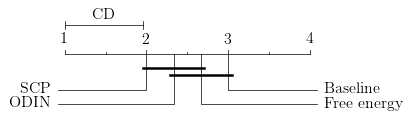

In [44]:
#@markdown ###CD Graph
from matplotlib.transforms import Bbox
from Orange.evaluation import compute_CD, graph_ranks
# Create an array of shape [auroc_scores, methods]
list_df = []
methods_to_test = list(df_results.groupby(df_results['OoD Method']).groups.keys())
#methods_to_test[3] = 'SCP'
for method in methods_to_test:
  list_df.append(df_results.loc[df_results['OoD Method'] == method][['AUROC']].to_numpy()/100)
auroc_results_per_method = np.concatenate(list_df, axis=1)
methods_to_test[3] = 'SCP' # To change the name in the figure

# Compute N and M
N = len(methods_to_test) # Models
M = np.shape(auroc_results_per_method)[0] # Datasets

order = np.argsort(-auroc_results_per_method, axis=1)
ranks = np.argsort(order, axis=1)+1
avgranks = np.mean(ranks, axis=0)

CD = compute_CD(avgranks, M)
graph_ranks(avgranks, methods_to_test, cd=CD, width=5, textspace=0.8)
plt.savefig(figures_path / f'CD_Graph_{model_choice}.pdf', bbox_inches='tight')
#plt.savefig(f'CD_Graph_{model_choice}.pdf', bbox_inches=Bbox([[0.2, 0], [0.8, 1]]))
plt.show()

In [ ]:
#@markdown Automated bayesian analysis (Signrank test)
scores_dict = OrderedDict()
methods_to_test = list(df_results.groupby(df_results['OoD Method']).groups.keys())
for method in methods_to_test:
  scores_dict[method] = df_results.loc[df_results['OoD Method'] == method][['AUROC']].to_numpy().squeeze()

# Select the rope (Region of Practical Equivalence)
ROPE = 0.025
methods_to_test.remove('Ours')
for method in methods_to_test:
  scores =  np.array(
      [[s1,s2] for (s1,s2) in zip(scores_dict['Ours'], scores_dict[method])]
  )

  modelLEFT = "Ours"
  modelRIGHT = method
  
  names = (modelLEFT, modelRIGHT)

  import bayesiantests as bt
  left, within, right = bt.signrank(scores/100, rope=ROPE, verbose=True, names=names)
  samples = bt.signrank_MC(scores/100, rope=ROPE)
  fig = bt.plot_posterior(samples, names)
  """
  if left > right:
    fig.set_title(f'Our method is better than {method} the {left*100:.2f}% of the times', y=0.92)
  elif left < right:
    fig.set_title(f'The {method} method is better than our method the {left*100:.2f}% of the times', y=0.92)
  else:
    fig.set_title(f'Our method and {method} method are practically equivalent the {left*100:.2f}% of the times', y=0.92)
  """
  plt.savefig(figures_path / f'signrank_test_{method}_{model_choice}_rope{ROPE}_better{left*100:.2f}.pdf', bbox_inches='tight')
  plt.show()

P(SCP > Baseline) = 0.95336, P(rope) = 0.0, P(Baseline > SCP) = 0.04664


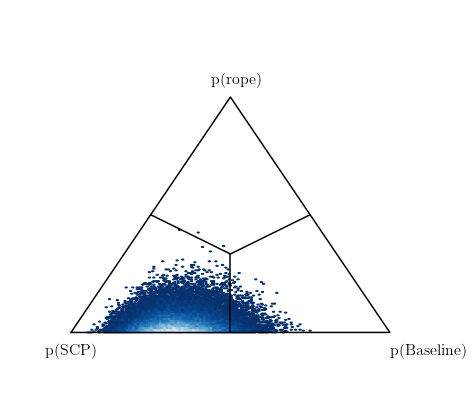

P(SCP > Free energy) = 0.85904, P(rope) = 0.00012, P(Free energy > SCP) = 0.14084


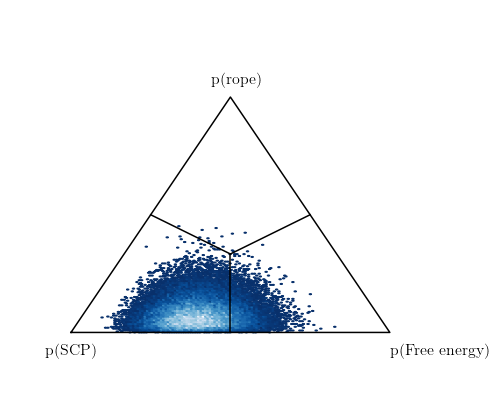

P(SCP > ODIN) = 0.79732, P(rope) = 4e-05, P(ODIN > SCP) = 0.20264


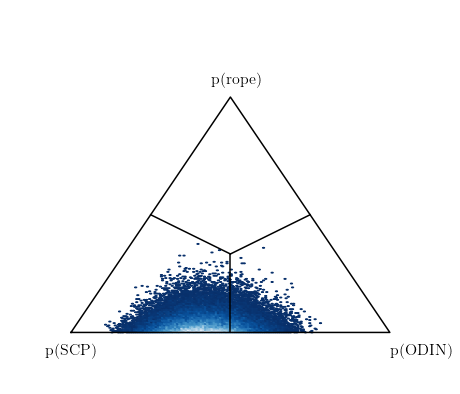

In [49]:
#@markdown Automated bayesian analysis (Signed test)
scores_dict = OrderedDict()
methods_to_test = list(df_results.groupby(df_results['OoD Method']).groups.keys())
for method in methods_to_test:
  scores_dict[method] = df_results.loc[df_results['OoD Method'] == method][['AUROC']].to_numpy().squeeze()

# Select the rope (Region of Practical Equivalence)
ROPE = 0.01
methods_to_test.remove('Ours')
for method in methods_to_test:
  scores =  np.array(
      [[s1,s2] for (s1,s2) in zip(scores_dict['Ours'], scores_dict[method])]
  )

  modelLEFT = "SCP"
  modelRIGHT = method
  
  names = (modelLEFT, modelRIGHT)

  #import bayesiantests as bt
  left, within, right = bt.signtest(scores/100, rope=ROPE, verbose=True, names=names)
  samples = bt.signtest_MC(scores/100, rope=ROPE)
  fig = bt.plot_posterior(samples,names)
  """
  if left > right:
    fig.set_title(f'Our method is better than {method} the {left*100:.2f}% of the times', y=0.92)
  elif left < right:
    fig.set_title(f'The {method} method is better than our method the {left*100:.2f}% of the times', y=0.92)
  else:
    fig.set_title(f'Our method and {method} method are practically equivalent the {left*100:.2f}% of the times', y=0.92)
  """
  plt.savefig(figures_path / f'signed_test_{method}_{model_choice}_rope{ROPE}_better{left*100:.2f}.pdf', bbox_inches='tight')
  plt.show()

# Dataset and model selection
---

In [ ]:
#@title #Dataset selection
#@markdown Click play once decided the in and out distributions to confirm the selection
IN_DATASET_NAME = 'MNIST' #@param ['MNIST','Fashion_MNIST','KMNIST', "Letters", 'MNIST_Square', 'CIFAR10']
OD_DATASET_NAME = 'MNIST_Square' #@param ['MNIST','Fashion_MNIST','KMNIST', 'Letters', 'MNIST_Square','CIFAR10-BW', 'omniglot', 'noMNIST', 'MNIST-C']


In [ ]:
#@markdown MNIST-C option selection
mnist_c_option = 'zigzag' #@param ['zigzag', 'scale', 'identity', 'motion_blur', 'canny_edges', 'glass_blur', 'translate', 'rotate', 'brightness', 'spatter', 'dotted_line', 'impulse_noise', 'fog', 'shear', 'stripe', 'shot_noise']

## Model selection

Available pretrained weights only for the indicated number of hidden neurons

Model type | Number of hidden neurons
--- | ---
Fully connected | 200
ConvNet | 300


In [ ]:
#@markdown Click play once decided to confirm the selection 
NUM_TIME_STEPS = 50
LR = 0.002
HEIGHT = 28
WIDTH = 28
INPUT_FEATURES = HEIGHT * WIDTH
selected_model = 'Fully_connected' #@param ['Fully_connected', 'ConvNet']
hidden_neurons = 200 #@param {type:"slider", min:100, max:500, step:25}
number_of_hidden_layers = "1" #@param [1, 2]
number_of_hidden_layers = int(number_of_hidden_layers)
output_neurons = 10
if IN_DATASET_NAME == 'Letters':
  output_neurons = 26
  model = load_model(selected_model, DEVICE, hidden_neurons, output_neurons,
                     number_of_hidden_layers)
else:
  model = load_model(selected_model, DEVICE, hidden_neurons, output_neurons,
                     number_of_hidden_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print(model)

Model(
  (encoder): PoissonEncoder()
  (snn): FC_SNN_1(
    (fc1): Linear(in_features=784, out_features=200, bias=False)
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), dt=0.001)
    (fc_out): Linear(in_features=200, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)


## Select to Train the model or to Load the pretrained weights (if available)

In [ ]:
load_or_train = 'Load' #@param ["Load", "Train"]
BATCH_SIZE = 256

# Load from the dictionary
train_data, train_loader, test_loader = IN_DISTRIBUTION_DATASETS[IN_DATASET_NAME](BATCH_SIZE)

# Load or create the DF to store the results. Also create the auxiliary list
hyperparams = []
hyperparams_path = Path("./model_hyperparameters.csv")
HYPERPARAMS_COLUMNS = ['In-Dataset', 'Model architecture', 'Number of steps', 
                       'Hidden neurons', 'Output neurons',
                       'Epochs', 'LR', 'Test accuracy']
if hyperparams_path.exists():
  df_model_hyperparams = pd.read_csv(hyperparams_path,
                                     sep=CSV_SEPARATOR, decimal=CSV_DECIMAL)
else:
  df_model_hyperparams = pd.DataFrame(columns=HYPERPARAMS_COLUMNS)

if load_or_train == 'Train':
  training_losses   = []
  mean_losses       = []
  test_losses       = []
  accuracies        = []

  EPOCHS = 10
  # Training loop
  for epoch in trange(EPOCHS, desc='Number of epochs', leave=False):
      _, mean_training_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
      mean_test_loss, accuracy, _ = test(model, DEVICE, test_loader)
      training_losses.append(mean_training_loss)
      test_losses.append(mean_test_loss)
      accuracies.append(accuracy)
      print(f"\nThe accuracy of the model with {IN_DATASET_NAME} for epoch {epoch+1} is {accuracies[-1]}%")

  #print(f"\nThe accuracy of the model with {IN_DATASET_NAME} is {accuracies[-1]}%")
  torch.save(model.state_dict(),f'state_dict_{IN_DATASET_NAME}_{selected_model}_{hidden_neurons}_{output_neurons}_{number_of_hidden_layers}_layers.pth')
  plot_loss_history(training_losses, test_losses)

  hyperparams = [[IN_DATASET_NAME, MODEL_NAME, NUM_TIME_STEPS, hidden_neurons,
                  output_neurons, EPOCHS, LR, accuracy]]
  df_one_model_hyperparams = pd.DataFrame(data=hyperparams, columns=HYPERPARAMS_COLUMNS)
  df_model_hyperparams = pd.concat([df_model_hyperparams, df_one_model_hyperparams])
  df_model_hyperparams.to_csv(hyperparams_path, index=False, sep=CSV_SEPARATOR, 
                              decimal=CSV_DECIMAL)


elif load_or_train == 'Load':
  model.load_state_dict(torch.load(pretrained_weights_path / f'state_dict_{IN_DATASET_NAME}_{selected_model}_{hidden_neurons}_{output_neurons}_{number_of_hidden_layers}_layers.pth'))
  model.eval()
  test_loss, accuracy, _ = test(model, DEVICE, test_loader, 0)
  print(f"\nThe accuracy of the model with loaded weights of {IN_DATASET_NAME} is {accuracy}%")

else:
  raise NameError('Wrong option introduced')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/Datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/Datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/Datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/Datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/Datasets/MNIST/raw


The accuracy of the model with loaded weights of MNIST is 96.15%


# Spike Count Pattern based detector (SCP)
---

## Extraction of hidden spikes and logits

In [ ]:
#@markdown ##Training subset to create the clusters
number_of_samples_per_class = 1200
selected_indices_per_class = indices_of_every_class_for_subset(
      train_loader,
      n_samples_per_class=number_of_samples_per_class,
      dataset_name=IN_DATASET_NAME
)
training_subset_clusters = torch.utils.data.Subset(train_data, [x for x in selected_indices_per_class])
subset_train_loader_clusters = torch.utils.data.DataLoader(training_subset_clusters, batch_size=256, shuffle=False)
if selected_model == 'ConvNet':
  accuracy_subset_train_clusters, preds_train_clusters, _, _spk_count_train_clusters = test(model, DEVICE, subset_train_loader_clusters, return_logits=True, return_conv_spikes=False)
else:
  accuracy_subset_train_clusters, preds_train_clusters, _, _spk_count_train_clusters = test(model, DEVICE, subset_train_loader_clusters, return_logits=True, return_conv_spikes=False)

print(f'Accuracy for the train subset is {accuracy_subset_train_clusters:.3f} %')

Accuracy for the train subset is 96.533 %


In [ ]:
#@markdown ##Training subset to create the thresholds to classify ood data
# If we have more than 10000 test samples, we limit it to 10000 mantaining a 
# balance in the number of samples predicted per class

# Introduce a the init_pos parameters to not select the same indices that for
# the subset for creating the clusters
selected_indices_per_class = indices_of_every_class_for_subset(
      train_loader,
      n_samples_per_class=1000,
      dataset_name=IN_DATASET_NAME,
      init_pos=number_of_samples_per_class*len(train_loader.dataset.classes)      
)
training_subset = torch.utils.data.Subset(train_data, [x for x in selected_indices_per_class])
subset_train_loader = torch.utils.data.DataLoader(training_subset, batch_size=BATCH_SIZE, shuffle=False)
# Extract the logits and the hidden spikes
if selected_model == 'ConvNet':
  accuracy_subset_train, preds_train, logits_train, _spk_count_train = test(model, DEVICE, subset_train_loader, return_logits=True, return_conv_spikes=False)
else:
  accuracy_subset_train, preds_train, logits_train, _spk_count_train = test(model, DEVICE, subset_train_loader, return_logits=True, return_conv_spikes=False)
print(f'Accuracy for the train subset is {accuracy_subset_train:.3f} %')

Accuracy for the train subset is 96.550 %


In [ ]:
#@markdown ##Test set to obtain the metrics

# Extract logits and hidden spikes
if selected_model == 'ConvNet':
  accuracy_test, preds_test, logits_test, _spk_count_test = test(model, DEVICE, test_loader, return_logits=True, return_conv_spikes=False)
else:
  accuracy_test, preds_test, logits_test, _spk_count_test = test(model, DEVICE, test_loader, return_logits=True, return_conv_spikes=False)
print(f'Accuracy for the test set of In-Distribution dataset is {accuracy_test:.3f} %')

Accuracy for the test set of In-Distribution dataset is 96.160 %


In [ ]:
#@markdown ##OoD test set
# Load from the dictionary
if OD_DATASET_NAME == 'MNIST-C':
  test_loader_ood = OUT_DISTRIBUTION_DATASETS[OD_DATASET_NAME](
      BATCH_SIZE,
      test_only=True,
      option=mnist_c_option
      )
else:
  test_loader_ood = OUT_DISTRIBUTION_DATASETS[OD_DATASET_NAME](BATCH_SIZE,
                                                               test_only=True)

# Extract logits and hidden spikes
if selected_model == 'ConvNet':
  accuracy_ood, preds_ood, logits_ood, _spk_count_ood = test(model, DEVICE, test_loader_ood, return_logits=True, return_conv_spikes=False)
else:
  accuracy_ood, preds_ood, logits_ood, _spk_count_ood = test(model, DEVICE, test_loader_ood, return_logits=True, return_conv_spikes=False)
print(f'Accuracy for the ood dataset {OD_DATASET_NAME} is {accuracy_ood:.3f} %')

Accuracy for the ood dataset MNIST_Square is 38.040 %


## Compute spike counts

In [ ]:
#@markdown Spike counts of hidden spikes
# In case we have returned the convolutional spikes, we will have a tuple 
# instead of an array, so we unpack the tuple first
print('Shape of the arrays')
print('-'*50)
spk_count_train_clusters = np.sum(_spk_count_train_clusters,axis=0, dtype='uint16')
print('Train subset for clusters:\t',spk_count_train_clusters.shape)
spk_count_train = np.sum(_spk_count_train,axis=0, dtype='uint16')
print('Train subset for threshold:\t', spk_count_train.shape)
# Test
spk_count_test = np.sum(_spk_count_test,axis=0, dtype='uint16')
print('Test set:\t\t\t', spk_count_test.shape)
# ood
spk_count_ood = np.sum(_spk_count_ood,axis=0, dtype='uint16')
print('ood set:\t\t\t', spk_count_ood.shape)

Shape of the arrays
--------------------------------------------------
Train subset for clusters:	 (12000, 200)
Train subset for threshold:	 (10000, 200)
Test set:			 (10000, 200)
ood set:			 (10000, 200)


## Training phase of the detector: Creating the clusters

Computing silhuette score for various distance thresholds:   0%|          | 0/10 [00:00<?, ?it/s]

Selected distance thresholds:
 [1326.5306122448978, 959.1836734693877, 1418.3673469387754, 1510.204081632653, 1142.8571428571427, 1510.204081632653, 1142.8571428571427, 1326.5306122448978, 1602.0408163265306, 1326.5306122448978]


Create the clusters with the selected distance thresholds: 0it [00:00, ?it/s]


Created clusters:
---------------------------------------------------------------------------
Clase 0 - zero        	 {0: 80, 1: 88, 2: 223, 3: 19, 4: 49, 5: 29, 6: 53, 7: 68, 8: 81, 9: 39, 10: 92, 11: 3, 12: 37, 13: 50, 14: 22, 15: 24, 16: 19, 17: 24}
---------------------------------------------------------------------------
Clase 1 - one         	 {0: 8, 1: 67, 2: 135, 3: 32, 4: 256, 5: 9, 6: 101, 7: 1, 8: 20, 9: 25, 10: 19, 11: 241, 12: 82, 13: 4}
---------------------------------------------------------------------------
Clase 2 - two         	 {0: 30, 1: 12, 2: 42, 3: 25, 4: 36, 5: 6, 6: 25, 7: 69, 8: 69, 9: 8, 10: 31, 11: 59, 12: 53, 13: 24, 14: 34, 15: 99, 16: 86, 17: 9, 18: 7, 19: 39, 20: 35, 21: 5, 22: 29, 23: 16, 24: 5, 25: 95, 26: 45, 27: 3, 28: 4}
---------------------------------------------------------------------------
Clase 3 - three       	 {0: 70, 1: 130, 2: 45, 3: 100, 4: 116, 5: 95, 6: 55, 7: 144, 8: 7, 9: 29, 10: 26, 11: 5, 12: 45, 13: 40, 14: 9, 15: 12, 16: 17, 

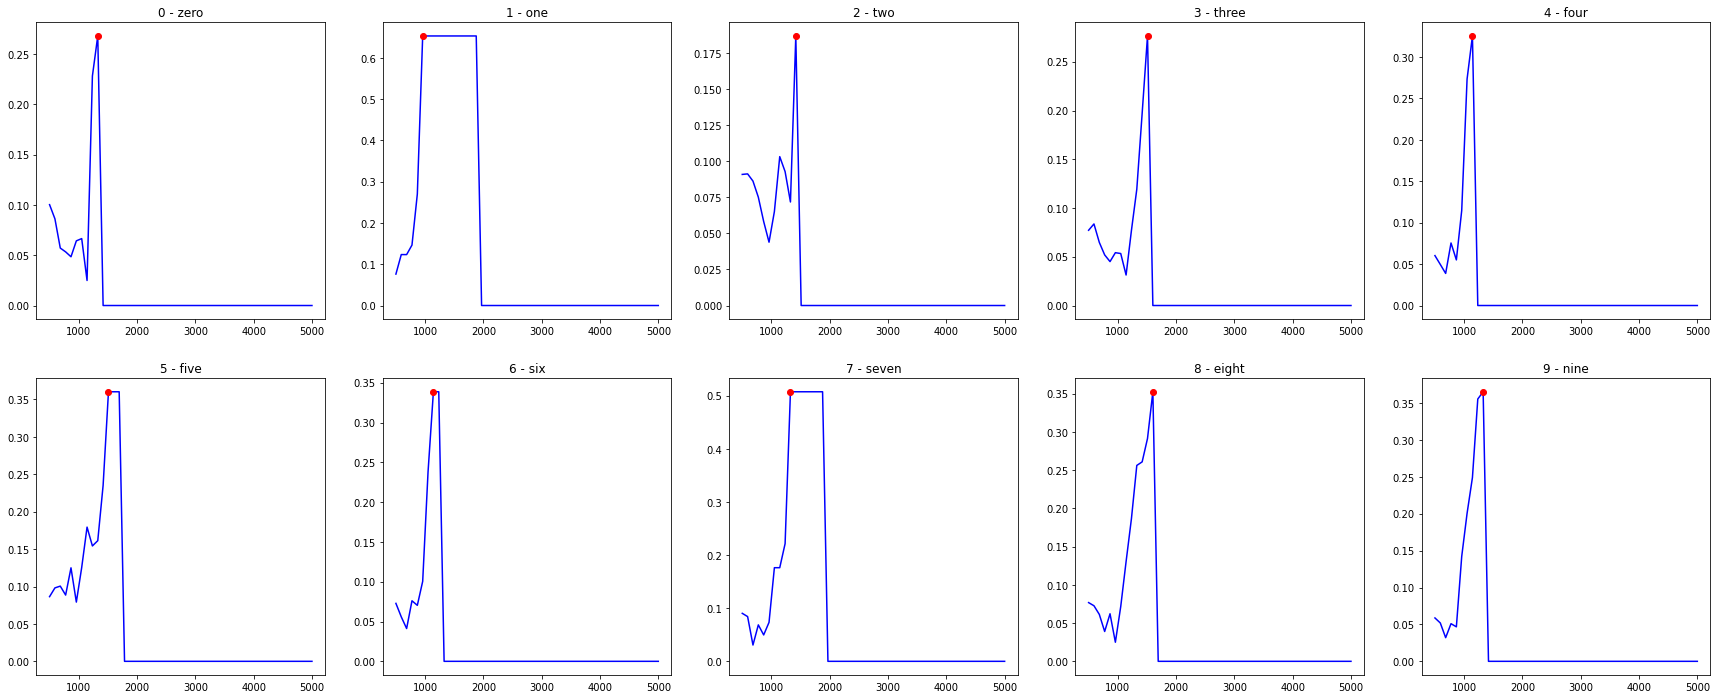

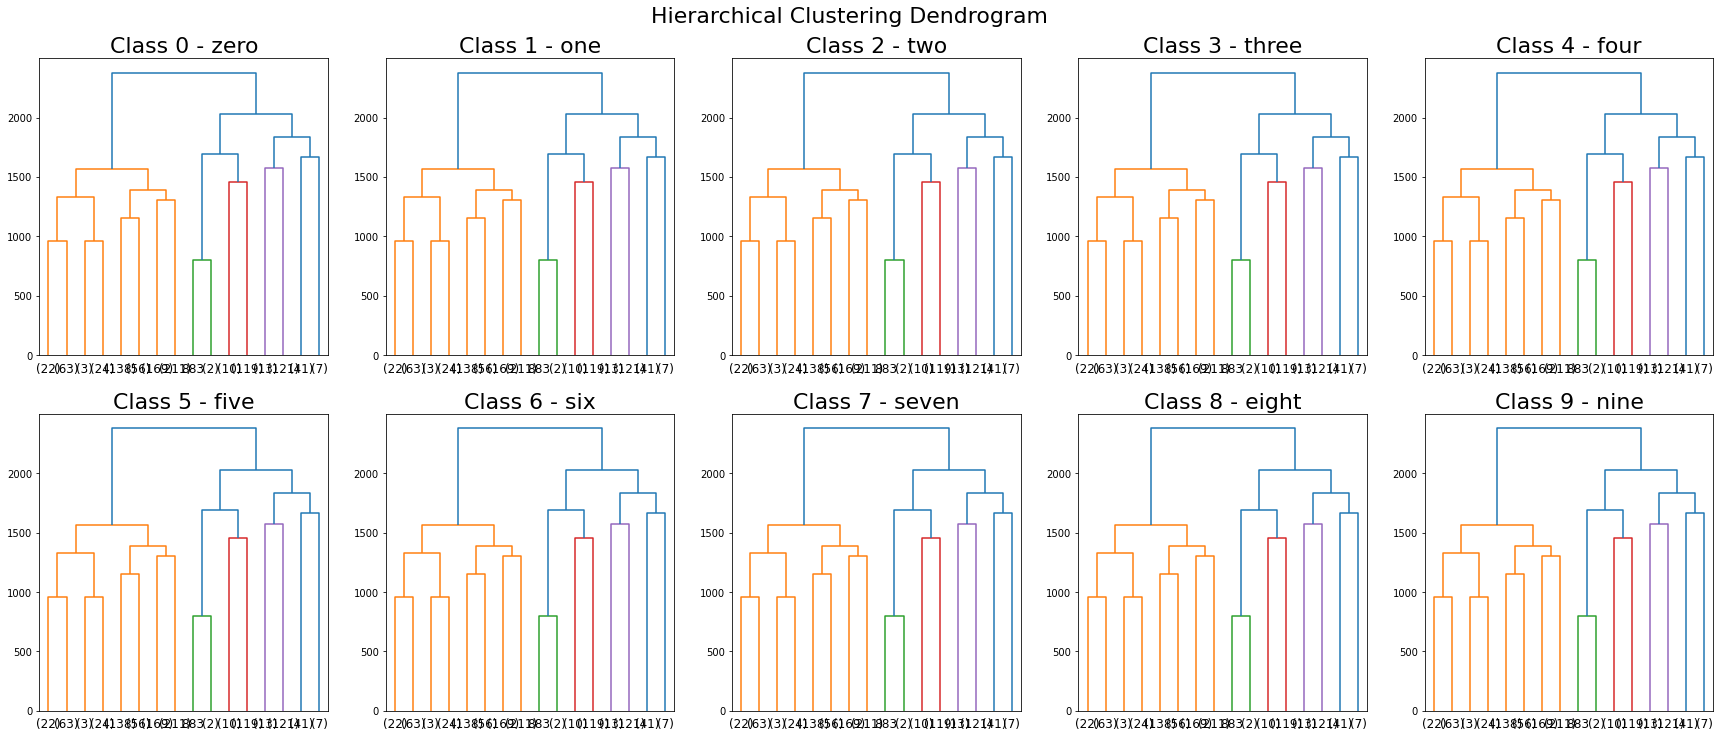

In [ ]:
#@markdown ##Compute the optimal clusters
dist_clustering = (500, 5000)

clusters_per_class = create_clusters(
    subset_train_loader_clusters,
    preds_train_clusters, 
    spk_count_train_clusters, 
    distance_for_clustering=dist_clustering)

In [ ]:
#@markdown ##Create the median aggregations for each cluster of each class
agg_counts_per_class_cluster = average_per_class_and_cluster(
    spk_count_train_clusters, 
    preds_train_clusters, 
    clusters_per_class,
    n_samples=1000,
    option='median'
)
print("Median aggregations computed succesfully!")

Median aggregations computed succesfully!


## Testing the detector

In [ ]:
#@title Computation of the distances of train, test and ood
distances_train_per_class, closest_clusters_per_cls_train = distance_to_clusters_averages(spk_count_train,preds_train,agg_counts_per_class_cluster)
distances_test_per_class, closest_clusters_per_cls_test = distance_to_clusters_averages(spk_count_test,preds_test,agg_counts_per_class_cluster)
distances_ood_per_class, closest_clusters_per_cls_ood = distance_to_clusters_averages(spk_count_ood,preds_ood,agg_counts_per_class_cluster)

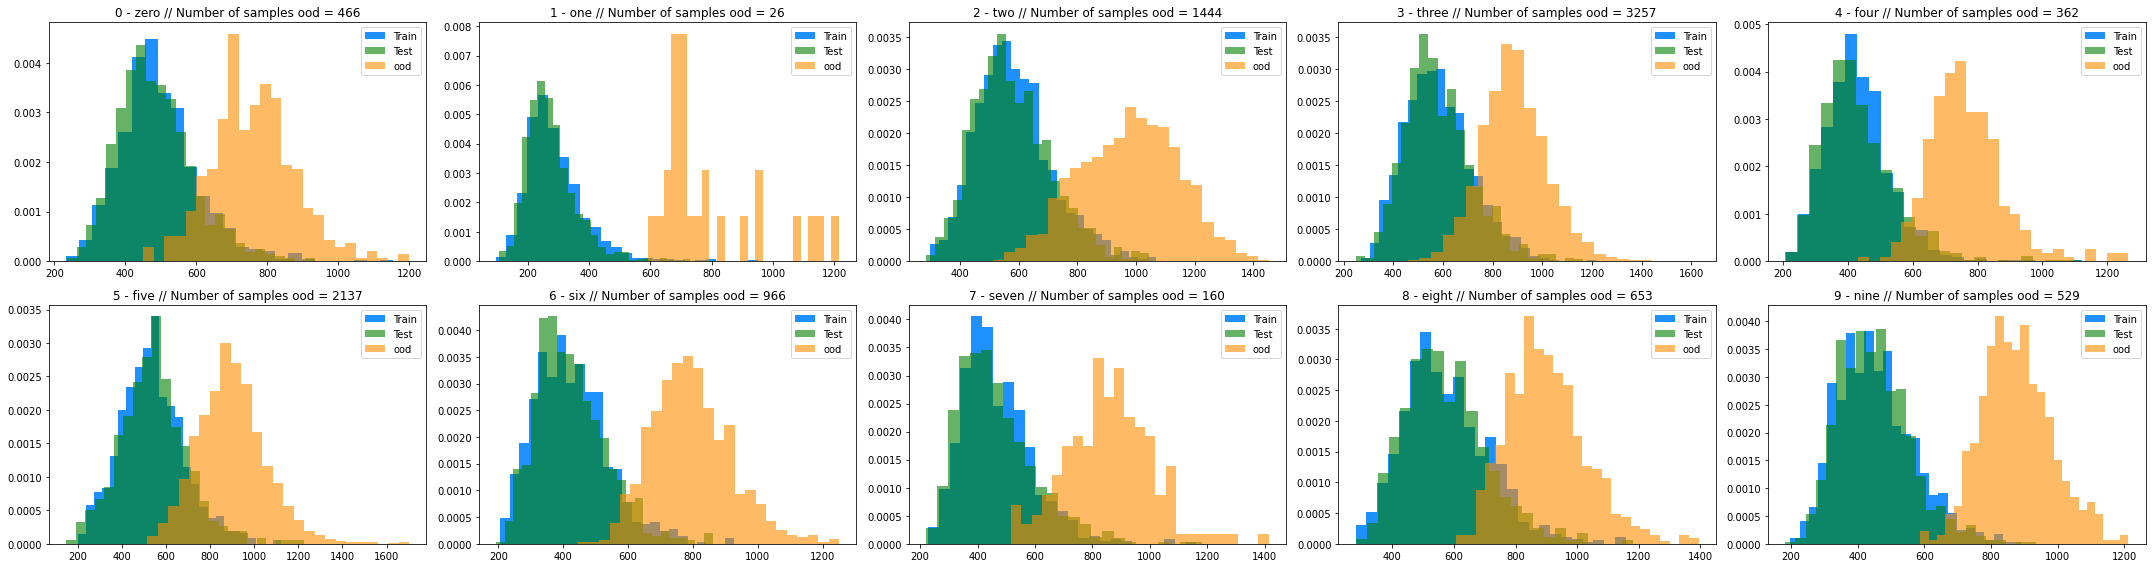

In [ ]:
#@title Classwise distance distribution
# Fuction to plot classwise distances
def plot_classwise_distances_to_cluster_averages(dist_train, dist_test, dist_ood, preds_ood, n_classes):
  if n_classes == 10:
    rows = 2
    cols = 5
  elif n_classes == 26:
    rows = 2
    cols = 13
  else:
    raise ValueError('Plot not implemented for that number of classes')

  fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows),
                             tight_layout=True)
  for class_index, ax in enumerate(axes.flat):
    n_samples = len(dist_ood[class_index])
    ood_bins = n_samples+1 if n_samples < 25 else 25
    ax.hist(dist_train[class_index],bins=25,color='dodgerblue',density=True, label='Train')
    ax.hist(dist_test[class_index],bins=25,color='green',alpha=0.6,density=True, label='Test')
    ax.hist(dist_ood[class_index],bins=ood_bins,color='darkorange',alpha=0.6,density=True, label='ood')
    ax.set_title(f'{train_data.classes[class_index]} // Number of samples ood = {len(preds_ood[searchIndicesOfClass(class_index,preds_ood)])}')
    ax.legend()
  return fig

fig = plot_classwise_distances_to_cluster_averages(
    distances_train_per_class, distances_test_per_class,
    distances_ood_per_class, preds_ood, len(train_loader.dataset.classes)
    )
#my_suptitle = fig.suptitle(f'{IN_DATASET_NAME} vs {OD_DATASET_NAME}', y=1.03, fontsize=15)
#fig.savefig(f'{IN_DATASET_NAME}_vs_{OD_DATASET_NAME}_Classwise_Distribution.pdf',
            #dpi=250, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

## Metrics

In [ ]:
#@markdown ##Threstholds calculation
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
distance_thresholds_train = thresholds_per_class_for_each_TPR(distances_train_per_class)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = compute_precision_tpr_fpr_for_test_and_ood(distances_test_per_class, distances_ood_per_class,distance_thresholds_train)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


------------------------------
Results
------------------------------
AUROC = 95.825 %
AUPR  = 96.477 %
------------------------------ 



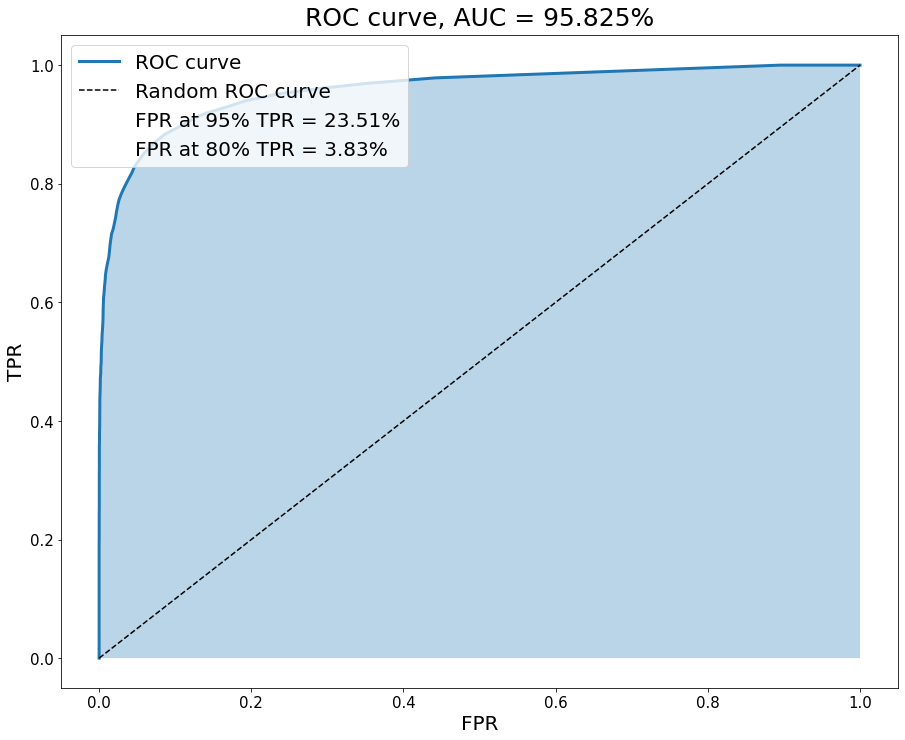

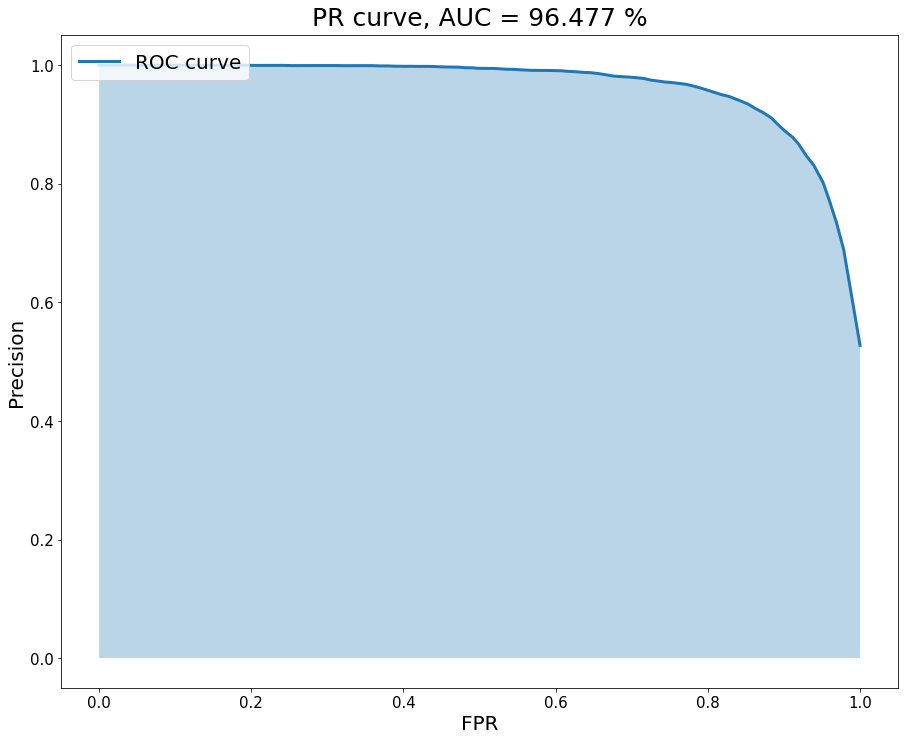

In [ ]:
#@title AUROC and AUPR
#AUROC
auroc = np.trapz(tpr_values_auroc, fpr_values_auroc)

# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(fpr_values_auroc,tpr_values_auroc,label='ROC curve', lw=3)
rnd_roc = plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--', label='Random ROC curve')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.title(f'ROC curve, AUC = {auroc*100:.3f}%', fontsize=25, pad=10)
plt.fill_between(fpr_values_auroc, tpr_values_auroc, alpha=0.3)
# Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label='FPR at 95% TPR = {}%'.format(round(fpr_values_auroc[95]*100,2)))
plt.plot([], [], ' ', label='FPR at 80% TPR = {}%'.format(round(fpr_values_auroc[80]*100,2)))
#plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
plt.legend(fontsize=20,loc='upper left')
#plt.axhline(y=0.95,linestyle='-',zorder=0)
#plt.axvline(x=array_TPR_FPR_x_threshold[95,1],linestyle='dashed',zorder=0)
#plt.savefig('/content/AUROC')
plt.savefig(f'/content/AUROC_{IN_DATASET_NAME}_vs_{OD_DATASET_NAME}.pdf')

# AUPR
aupr = np.trapz(precision, tpr_values)
# Plot
plt.figure(figsize=(15,12))
roc = plt.plot(tpr_values,precision,label='ROC curve',lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title(f'PR curve, AUC = {aupr*100:.3f} %', fontsize=25, pad=10)
plt.fill_between(tpr_values,precision,alpha=0.3)
plt.legend(fontsize=20,loc='upper left')
plt.savefig(f'/content/AUPR_{IN_DATASET_NAME}_vs_{OD_DATASET_NAME}.pdf')

print('-'*30)
print(f'Results')
print('-'*30)
print(f'AUROC = {auroc*100:.3f} %')
print(f'AUPR  = {aupr*100:.3f} %')
print('-'*30,'\n')

# OoD detection benchmark

To change between different datasets:

1. You must go to the training stage, select the In and Out datasets, and retrain the model or load it with the corresponding weights
2. Recompute the Spike and logits extraction
3. Compute all the cells of the OoD method you want to test again

## Baseline method

DISCLAIMER: 

---

This method is inspired by the baseline method (http://arxiv.org/abs/1610.02136) but does not follow the exact implementation of the paper, as we want the method to be comparable with ours. Therefore, as we don't make usage of prior knowledge of the predicted class, in our implementation of the baseline method we don't make the distinction between correctly and incorrectly classified samples.

In [ ]:
#@markdown Max softmax probailities
# Winners
softmax_train_winners = np.max(scysp.softmax(logits_train, axis=1),axis=1)
softmax_test_winners = np.max(scysp.softmax(logits_test, axis=1),axis=1)
softmax_ood_winners = np.max(scysp.softmax(logits_ood, axis=1),axis=1)

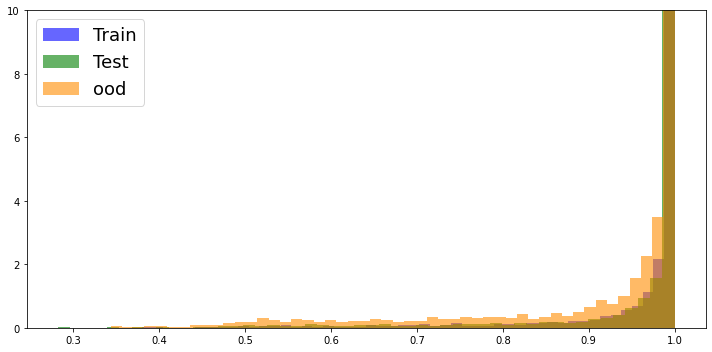

In [ ]:
#@markdown Histogram of softmax probabilities of train, test and ood
fig = plt.figure(figsize=(10,5),tight_layout=True)
plt.hist(softmax_train_winners,bins=50,color='blue',alpha=0.6,density=True, label='Train')
plt.hist(softmax_test_winners,bins=50,color='green',alpha=0.6,density=True, label='Test')
plt.hist(softmax_ood_winners,bins=50,color='darkorange',alpha=0.6,density=True, label='ood')
plt.ylim([0,10])
plt.legend(fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in true_divide


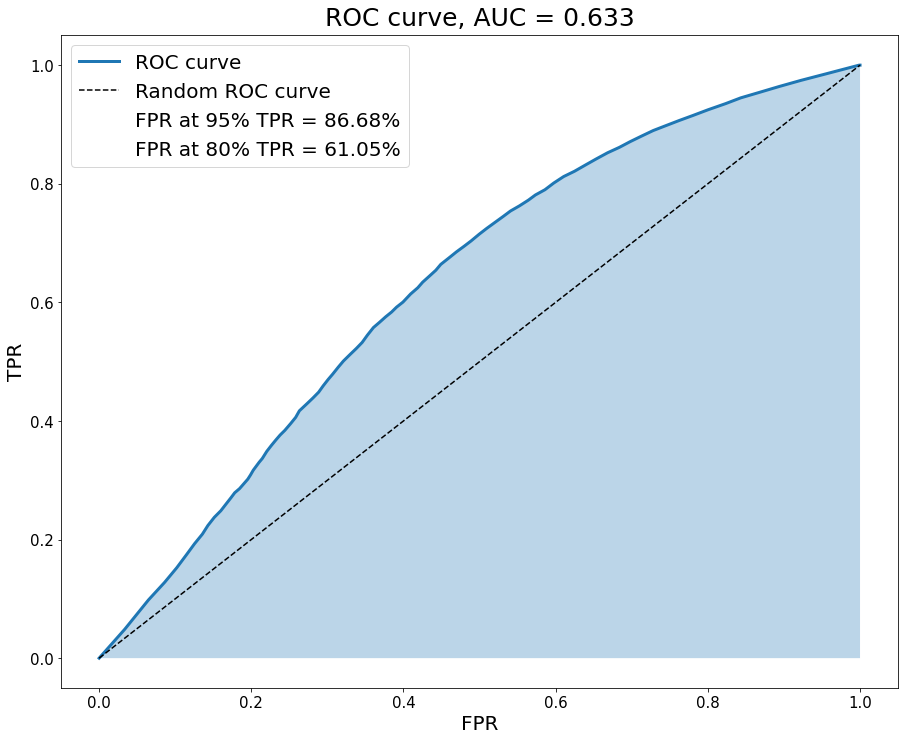

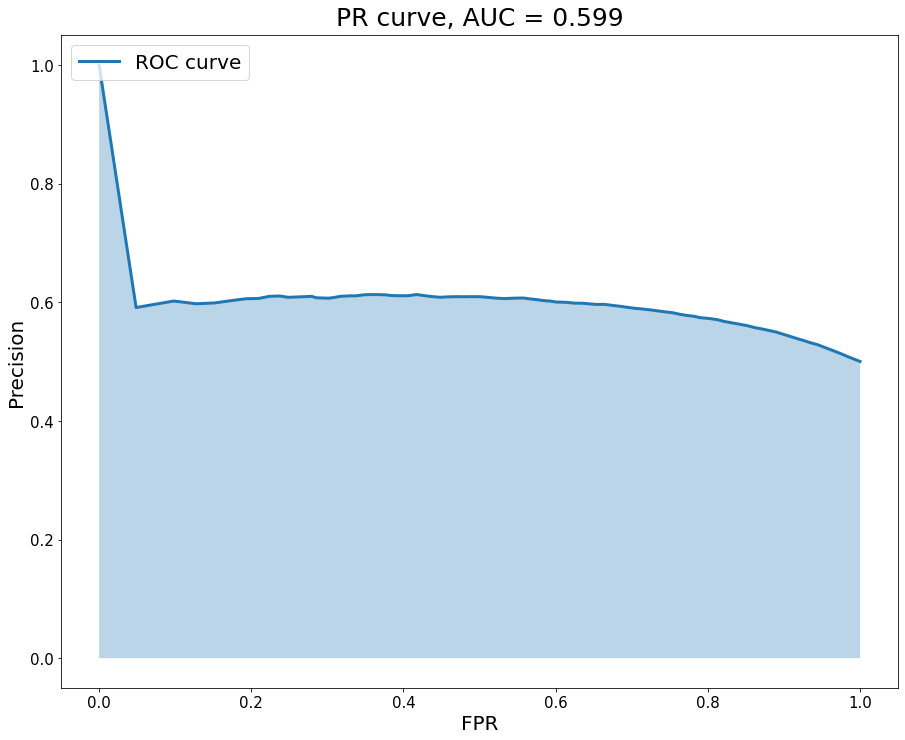

In [ ]:
#@markdown ##Metrics
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
likelihood_thresholds_train = thresholds_for_each_TPR_likelihood(softmax_train_winners)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(softmax_test_winners, softmax_ood_winners, likelihood_thresholds_train)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

# Plot AUROC
plot_AUROC(fpr_values_auroc, tpr_values_auroc)

# Plot AUPR
plot_AUPR(precision, tpr_values)

## ODIN

### Select the temperature manually

In [ ]:
#@markdown Temperature scaling the softmax
temp= 1 #@param {type:"number"}
temp_softmax_train = scysp.softmax(logits_train/temp,axis=1)
temp_softmax_test = scysp.softmax(logits_test/temp,axis=1)
temp_softmax_ood = scysp.softmax(logits_ood/temp,axis=1)
# Getting only the winners
temp_softmax_train_winners = np.max(temp_softmax_train,axis=1)
temp_softmax_test_winners = np.max(temp_softmax_test,axis=1)
temp_softmax_ood_winners = np.max(temp_softmax_ood,axis=1)

In [ ]:
#@markdown Histogram of softmax probabilities of train, test and ood
fig = plt.figure(figsize=(10,5),tight_layout=True)
plt.hist(temp_softmax_train_winners,bins=50,color='blue',alpha=0.6,density=True, label='Train')
plt.hist(temp_softmax_test_winners,bins=50,color='green',alpha=0.6,density=True, label='Test')
plt.hist(temp_softmax_ood_winners,bins=50,color='darkorange',alpha=0.6,density=True, label='ood')
#plt.ylim([0,10])
plt.legend(fontsize=18)
plt.show()

In [ ]:
#@markdown Metrics
# Execute the functions
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
likelihood_thresholds_train = thresholds_for_each_TPR_likelihood(temp_softmax_train_winners)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(temp_softmax_test_winners, temp_softmax_ood_winners, likelihood_thresholds_train)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

# Plot AUROC
plot_AUROC(fpr_values_auroc, tpr_values_auroc)

# Plot AUPR
plot_AUPR(precision, tpr_values)

### Testing metrics for several temperatures

In [ ]:
#@markdown AUROC and AUPR for different temperatures
for temp in [1, 10, 100, 1000, 10000]:
  # Temperature scaling the softmax
  temp_softmax_train = scysp.softmax(logits_train/temp,axis=1)
  temp_softmax_test = scysp.softmax(logits_test/temp,axis=1)
  temp_softmax_ood = scysp.softmax(logits_ood/temp,axis=1)
  # Getting only the winners
  temp_softmax_train_winners = np.max(temp_softmax_train,axis=1)
  temp_softmax_test_winners = np.max(temp_softmax_test,axis=1)
  temp_softmax_ood_winners = np.max(temp_softmax_ood,axis=1)
  #fig = plt.figure(figsize=(10,5),tight_layout=True)
  #plt.hist(temp_softmax_train_winners,bins=50,color='blue',alpha=0.6,density=True, label='Train')
  #plt.hist(temp_softmax_test_winners,bins=50,color='green',alpha=0.6,density=True, label='Test')
  #plt.hist(temp_softmax_ood_winners,bins=50,color='darkorange',alpha=0.6,density=True, label='ood')
  #plt.ylim([0,10])
  #plt.legend(fontsize=18)
  #plt.show()
  # Execute the functions
  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  likelihood_thresholds_train = thresholds_for_each_TPR_likelihood(temp_softmax_train_winners)
  # Conmputing precision, tpr and fpr
  precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(temp_softmax_test_winners, temp_softmax_ood_winners, likelihood_thresholds_train)
  # Appending that when FPR = 1 the TPR is also 1:
  tpr_values_auroc = np.append(tpr_values,1)
  fpr_values_auroc = np.append(fpr_values,1)

  # Plot AUROC
  #plot_AUROC(fpr_values_auroc, tpr_values_auroc)

  # Plot AUPR
  #plot_AUPR(precision, tpr_values)

  # AUROC
  auroc = np.trapz(tpr_values_auroc, fpr_values_auroc)

  # AUPR
  aupr = np.trapz(precision, tpr_values)

  #results.append([temp, auroc, aupr])

  print('-'*30)
  print(f'Results for temperature = {temp}')
  print('-'*30)
  print(f'AUROC = {auroc*100:.3f} %')
  print(f'AUPR  = {aupr*100:.3f} %')
  print('-'*30,'\n')


------------------------------
Results for temperature = 1
------------------------------
AUROC = 63.288 %
AUPR  = 59.947 %
------------------------------ 

------------------------------
Results for temperature = 10
------------------------------
AUROC = 61.651 %
AUPR  = 57.896 %
------------------------------ 

------------------------------
Results for temperature = 100
------------------------------
AUROC = 61.169 %
AUPR  = 57.550 %
------------------------------ 

------------------------------
Results for temperature = 1000
------------------------------
AUROC = 61.124 %
AUPR  = 57.509 %
------------------------------ 

------------------------------
Results for temperature = 10000
------------------------------
AUROC = 61.119 %
AUPR  = 57.505 %
------------------------------ 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in true_divide


## Energy-based ood detection

### Select the temperature manually

In [ ]:
#@markdown Compute energy
temp = 1 #@param {type:"number"}
energy_train = -(-temp*torch.logsumexp(torch.Tensor(logits_train) / temp, dim=1)).numpy()
energy_test = -(-temp*torch.logsumexp(torch.Tensor(logits_test) / temp, dim=1)).numpy()
energy_ood = -(-temp*torch.logsumexp(torch.Tensor(logits_ood) / temp, dim=1)).numpy()

In [ ]:
#@markdown Plot histogram of the free energy
plot_histogram(energy_train, energy_test, energy_ood)

In [ ]:
#@markdown ##Metrics
# Execute the functions
# Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
distance_thresholds_train = thresholds_for_each_TPR_likelihood(energy_train)
# Conmputing precision, tpr and fpr
precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(energy_test, energy_ood, distance_thresholds_train)
# Appending that when FPR = 1 the TPR is also 1:
tpr_values_auroc = np.append(tpr_values,1)
fpr_values_auroc = np.append(fpr_values,1)

# Plot AUROC
plot_AUROC(fpr_values_auroc, tpr_values_auroc)

# Plot AUPR
plot_AUPR(precision, tpr_values)

### Testing metrics for several temperatures

In [ ]:
#@markdown AUROC and AUPR for different temperatures
results = []
temperatures = [1,10,100,1000,10000, 100000]
for temp in temperatures:
  # Compute the energies 
  energy_train = -(-temp*torch.logsumexp(torch.Tensor(logits_train) / temp, dim=1)).numpy()
  energy_test = -(-temp*torch.logsumexp(torch.Tensor(logits_test) / temp, dim=1)).numpy()
  energy_ood = -(-temp*torch.logsumexp(torch.Tensor(logits_ood) / temp, dim=1)).numpy()

  # Creation of the array with the thresholds for each TPR (class, dist_per_TPR)
  distance_thresholds_train = thresholds_for_each_TPR_likelihood(energy_train)
  # Conmputing precision, tpr and fpr
  precision, tpr_values, fpr_values = likelihood_method_compute_precision_tpr_fpr_for_test_and_ood(energy_test, energy_ood, distance_thresholds_train)
  # Appending that when FPR = 1 the TPR is also 1:
  tpr_values_auroc = np.append(tpr_values,1)
  fpr_values_auroc = np.append(fpr_values,1)

  # AUROC
  auroc = np.trapz(tpr_values_auroc, fpr_values_auroc)

  # AUPR
  aupr = np.trapz(precision, tpr_values)

  results.append([temp, auroc, aupr])
# Print results
for res in results:
  print('-'*30)
  print(f'Results for temperature = {res[0]}')
  print('-'*30)
  print(f'AUROC = {res[1]*100:.3f} %')
  print(f'AUPR  = {res[2]*100:.3f} %')
  print('-'*30,'\n')

------------------------------
Results for temperature = 1
------------------------------
AUROC = 60.103 %
AUPR  = 56.781 %
------------------------------ 

------------------------------
Results for temperature = 10
------------------------------
AUROC = 53.111 %
AUPR  = 51.763 %
------------------------------ 

------------------------------
Results for temperature = 100
------------------------------
AUROC = 45.346 %
AUPR  = 47.940 %
------------------------------ 

------------------------------
Results for temperature = 1000
------------------------------
AUROC = 44.703 %
AUPR  = 47.513 %
------------------------------ 

------------------------------
Results for temperature = 10000
------------------------------
AUROC = 44.637 %
AUPR  = 47.444 %
------------------------------ 

------------------------------
Results for temperature = 100000
------------------------------
AUROC = 44.611 %
AUPR  = 47.425 %
------------------------------ 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in true_divide


# Explainability

Instructions:
- Set the LaTeX fonts for the plots if you want using the cell below
- Compute the prerequisites to enable the plots to work
- The figure of the paper has its own prerequisites in its section befor the plot


In [ ]:
#@markdown  ## Set LaTeX fonts for matplotlib
!apt-get update
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# Set LaTex font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Latin Modern Sans"})

## Prerequisites

In [ ]:
#@markdown ##Retrieve weigths from the model
if number_of_hidden_layers == 1:
  if selected_model == 'ConvNet':
    weights = model.snn.state_dict()['fc1.weight'].cpu().numpy()
  elif selected_model == 'Fully_connected':
    weights = model.state_dict()['snn.fc1.weight'].cpu().numpy()
  else:
    raise NameError


elif number_of_hidden_layers > 1:
  if selected_model == 'ConvNet':
    weights = [
              model.snn.state_dict()['fc2.weight'].cpu().numpy(),
              model.snn.state_dict()['fc1.weight'].cpu().numpy(),
              ]
  elif selected_model == 'Fully_connected':
    weights = [
              model.snn.state_dict()['fc2.weight'].cpu().numpy(),
              model.snn.state_dict()['fc1.weight'].cpu().numpy(),
              ]
  else:
    raise NameError

else:
  raise ValueError('Wrong number of layers')

In [ ]:
#@markdown ##Computation of the distances of train, test and ood 
distances_train_per_class, closest_clusters_per_cls_train = distance_to_clusters_averages(spk_count_train,preds_train,agg_counts_per_class_cluster)
distances_test_per_class, closest_clusters_per_cls_test = distance_to_clusters_averages(spk_count_test,preds_test,agg_counts_per_class_cluster)
distances_ood_per_class, closest_clusters_per_cls_ood = distance_to_clusters_averages(spk_count_ood,preds_ood,agg_counts_per_class_cluster)

In [ ]:
#@markdown ##Create the reconstruction
# Compute reconst
reconst_test = compute_reconstruction(spk_count_test, weights)
reconst_ood = compute_reconstruction(spk_count_ood, weights)
# Extract positive part
reconst_test = np.where(reconst_test >= 0, reconst_test, 0)
reconst_ood = np.where(reconst_ood >= 0, reconst_ood, 0)

### Backprop the hidden counts of the median ###
agg_counts_reconstructed_per_class_and_cluster = compute_reconstruction_per_class(agg_counts_per_class_cluster, weights)
# Extract the positive part
avg_frecs_reconst_per_cl_clu_positive = extract_positive_part_per_class(agg_counts_reconstructed_per_class_and_cluster)

if selected_model == 'ConvNet':
  # Rearrange
  reconst_test = rearrange_to_ftmaps(reconst_test, ftmaps_shape=(50, 11, 11))
  reconst_ood = rearrange_to_ftmaps(reconst_ood, ftmaps_shape=(50, 11, 11))
  avg_frecs_reconst_per_cl_clu_positive = rearrange_to_ftmaps_per_class(avg_frecs_reconst_per_cl_clu_positive, (50,11,11))

# Reorder to be a list of reconstructions per class
reconst_per_class_test = order_array_of_samples_to_per_class_list(reconst_test, preds_test)
reconst_per_class_ood = order_array_of_samples_to_per_class_list(reconst_ood, preds_ood)

In [ ]:
#@markdown ##Show AUROC and AUPR and extract distance thresholds
thresholds = auroc_aupr(distances_train_per_class, distances_test_per_class, distances_ood_per_class)

------------------------------
Results
------------------------------
AUROC = 95.825 %
AUPR  = 96.477 %
------------------------------
FPR at 95% TPR: 23.51%
Threshold mean and std for all classes at 95% TPR: 701.90, 113.17
------------------------------ 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#@markdown ##Define the plot range
# To define the plot range we take 100 examples of test and process them to
# obtain the attribution. Then, we take the quantile 80 of all the pixel values
# in the 100 examples taken. 
array_histrogram = np.zeros((100, 28, 28), dtype='float32')
for ind, i in tqdm(enumerate(np.random.randint(0, 10000, 100))):
  prediction = preds_test[i]
  # Obtain the index of the represented number in the per class order to extract the closest cluster (as it is in per class order)
  i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_test) == np.array(i))[0][0]
  if selected_model == 'ConvNet':
    array_histrogram[ind] = resize(np.sum(np.abs(reconst_test[i] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_test[prediction][i_in_per_cls_order]]), axis=0), (28, 28))
  elif selected_model == 'Fully_connected':
    array_histrogram[ind] = np.abs(reconst_test[i] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_test[prediction][i_in_per_cls_order]]).reshape(28,28)
  else:
    raise NameError
plot_range = [int(np.quantile(array_histrogram.flatten(), 0.90)), int(np.max(array_histrogram.flatten()))]
print("Plot range for heatmaps:", plot_range)

array_histrogram = np.zeros((100, 28, 28), dtype='float32')
for ind, i in tqdm(enumerate(np.random.randint(0, 10000, 100))):
  prediction = preds_test[i]
  # Obtain the index of the represented number in the per class order to extract the closest cluster (as it is in per class order)
  i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_test) == np.array(i))[0][0]
  if selected_model == 'ConvNet':
    array_histrogram[ind] = resize(np.sum(reconst_test[i], axis=0), (28, 28))
  elif selected_model == 'Fully_connected':
    array_histrogram[ind] = reconst_test[i].reshape(28,28)
  else:
    raise NameError
plot_range_inputs = [int(np.quantile(array_histrogram.flatten(), 0.80)), int(np.max(array_histrogram.flatten()))]
max_plot_value_inputs = plot_range_inputs[1]
print("Plot max value for inputs:", max_plot_value_inputs)

0it [00:00, ?it/s]

Plot range for heatmaps: [20, 102]


0it [00:00, ?it/s]

Plot max value for inputs: 288


## Plot type #1

In [ ]:
#@markdown ##Plot attribution test
initial_pos = 0
rows = 10
cols = 20
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
fig.suptitle("In every two columns, the first representes the image with the heatmap superimposed and the second is the heatmap alone\n" \
             "The number above the images correspond to the difference between the OOD score of the image to the closest centroid compared with the threshold if set to obtain a 80% FPR", fontsize=20, y=0.94)
for cl_ind, ax_row in enumerate(axes):
  # Extract the indices of the correspondent examples
  ind = searchIndicesOfClass(cl_ind, preds_test)
  ind = ind[initial_pos:] # To start from the selected initial position
  preds_test = preds_test[initial_pos:] # To start from the selected initial position

  for col, ax in enumerate(ax_row):
    ax.set_xticks([])
    ax.set_yticks([])

    # For distinguising even and odd columns
    if col % 2 == 0:
      # Compute the distance compared to the threshold at the FPR seleted
      dist = distances_test_per_class[cl_ind][col//2 + initial_pos]
      which_fpr = 80 # To select the FPR (80 or 95)
      if dist - thresholds[preds_test[col//2], which_fpr] >= 0:
        distance_to_centroid = '+ ' + str(dist - thresholds[preds_test[col//2], which_fpr])
      else:
        distance_to_centroid = '\N{MINUS SIGN} ' + str(abs(dist - thresholds[preds_test[col//2], which_fpr]))
      # Plot image of the number and title 
      ax.imshow(test_loader.dataset[ind[col//2]][0].squeeze(), cmap="binary")
      alpha=0.65
      ax.set_title(f'{distance_to_centroid}', fontsize=12)
    else:
      alpha=1 # No transparency if no image is superimposed

    # The image to be plotted
    img = np.abs(reconst_per_class_test[cl_ind][col//2 + initial_pos] - avg_frecs_reconst_per_cl_clu_positive[cl_ind][closest_clusters_per_cls_test[cl_ind][col//2 + initial_pos]])
    if selected_model == "ConvNet":
      img = resize(np.sum(img, axis=0), (28,28))

    # Plot the image
    im = ax.imshow(np.reshape(img, (28,28)),
                   alpha=alpha, vmin=plot_range[0], vmax=plot_range[1], cmap='Reds')
    # The first column includes the predicted label for all the row
    if col == 0:
      ax.set_ylabel(train_data.classes[cl_ind], fontsize=18)
    if col % 2 == 1:
      #plt.colorbar(im, ax=ax)
      pass
plt.show()

In [ ]:
#@markdown ##Plot attribution OOD
rows = 10
cols = 20
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
fig.suptitle("In every two columns, the first representes the image with the heatmap superimposed and the second is the heatmap alone\n" \
             "The number above the images correspond to the difference between the OOD score of the image to the closest centroid compared with the threshold if set to obtain a 80% FPR", fontsize=20, y=0.94)
for cl_ind, ax_row in enumerate(axes):
  ind = searchIndicesOfClass(cl_ind, preds_ood)
  ind = ind[initial_pos:]
  preds_ood = preds_ood[initial_pos:]
  for col, ax in enumerate(ax_row):
    ax.set_xticks([])
    ax.set_yticks([])

    # For distinguising even and odd columns
    if col % 2 == 0:
      # Compute the distance compared to the threshold at the FPR seleted
      dist = distances_ood_per_class[cl_ind][col//2 + initial_pos]
      which_fpr = 80 # To select the FPR (80 or 95)
      if dist - thresholds[preds_ood[col//2], which_fpr] >= 0:
        distance_to_centroid = '+ ' + str(dist - thresholds[preds_ood[col//2], which_fpr])
      else:
        distance_to_centroid = '\N{MINUS SIGN} ' + str(abs(dist - thresholds[preds_ood[col//2], which_fpr]))

      ax.imshow(test_loader_ood.dataset[ind[col//2]][0].squeeze(), cmap="binary")
      alpha=0.65
      ax.set_title(f'{distance_to_centroid}')
    else:
      alpha=1 # No transparency if no image is superimposed

    # Compute the image to be plotted
    img = np.abs(reconst_per_class_ood[cl_ind][col//2 + initial_pos] - avg_frecs_reconst_per_cl_clu_positive[cl_ind][closest_clusters_per_cls_ood[cl_ind][col//2 + initial_pos]])
    if selected_model == "ConvNet":
      img = resize(np.sum(img, axis=0), (28,28))
      
    # Plot the image
    im = ax.imshow(np.reshape(img, (28,28)),  
                   alpha=alpha,  vmin=plot_range[0], vmax=plot_range[1], cmap='Reds')
    
    # The first column includes the predicted label for all the row
    if col == 0:
      ax.set_ylabel(train_data.classes[cl_ind], fontsize=18)
    if col % 2 == 1:
      #plt.colorbar(im, ax=ax)
      pass
plt.show()

## Plot type #2

In [ ]:
#@markdown ##Reconstruction of the input
initial_pos = 0
transp = 0.65
clr_map = 'Reds'
fig, axes = plt.subplots(10,15, figsize=(35,18))
fig.suptitle(f'First part of the title is the actual label of the image, on the left of the first column is the predicted class for that entire row\n' \
             "The second part of the title is the difference between the OOD score of the image to the closest centroid compared with the threshold if set to obtain a 80% FPR", fontsize=22, y=0.93)
for cl_index, ax_row in enumerate(axes):
  indices_test = np.array(searchIndicesOfClass(cl_index, preds_test, 7, initial_pos), dtype='uint16')
  indices_ood = np.array(searchIndicesOfClass(cl_index, preds_ood, 8, initial_pos), dtype='uint16')
  indices = np.concatenate((indices_test, indices_ood), dtype='uint16')
  for index, ax in enumerate(ax_row):
    ax.set_xticks([])
    ax.set_yticks([])

    # First part of the image for test images
    if index < 7:
      reconst = reconst_per_class_test[cl_index][index+initial_pos]
      ax.imshow(test_loader.dataset[indices[index]][0].squeeze(), cmap='binary')
      if selected_model == "ConvNet":
        reconst = resize(np.sum(reconst, axis=0), (28,28))
      im = ax.imshow(reconst.reshape(28,28), vmin=0, vmax=max_plot_value_inputs, cmap=clr_map, alpha=transp)

      # Compute distance to centroid for title
      dist = distances_test_per_class[cl_index][index+initial_pos]
      if dist - thresholds[cl_index, WHICH_FPR] >= 0:
        distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
      else:
        distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))
      ax.set_title(test_loader.dataset.classes[test_loader.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=11, pad=3)

    # Second part of the image for OoD images
    else: 
      try: # In case there are no sufficient OoD images for a row, skip the space left for that row
        # Extract the reconstruction
        reconst = reconst_per_class_ood[cl_index][index+initial_pos-7]
        # Plot the image
        ax.imshow(test_loader_ood.dataset[indices[index]][0].squeeze(), cmap='binary')
        # In case the model is a ConvNet, we must sum over channels and resize
        if selected_model == "ConvNet":
          reconst = resize(np.sum(reconst, axis=0), (28,28))

        # Compute distance to centroid for title
        dist = distances_ood_per_class[cl_index][index+initial_pos-7]
        if dist - thresholds[cl_index, WHICH_FPR] >= 0:
          distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
        else:
          distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))
        
        im = ax.imshow(reconst.reshape(28,28), vmin=-0, vmax=max_plot_value_inputs, cmap=clr_map, alpha=transp)
        try:
          ax.set_title(test_loader_ood.dataset.classes[test_loader_ood.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=11, pad=3)
        except AttributeError:
          ax.set_title(f'{int(distances_ood_per_class[cl_index][index+initial_pos-7])}', fontsize=11, pad=3)
      except IndexError:
        ax.axis('off')

    if index == 0:
      ax.set_ylabel(train_data.classes[cl_index], fontsize=18)
plt.colorbar(im, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
plt.show()

In [ ]:
#@markdown ##Reconstruction of the median closest to the correspondent image
initial_pos = 0
transp = 1
rep_range = plot_range_inputs[1]
clr_map = 'Reds'
fig, axes = plt.subplots(10,15, figsize=(35,18))
fig.suptitle(f'First part of the title is the actual label of the image, on the left of the first column is the predicted class for that entire row\n' \
             "The second part of the title is the difference between the OOD score of the image to the closest centroid compared with the threshold if set to obtain a 80% FPR", fontsize=22, y=0.93)
for cl_index, ax_row in enumerate(axes):
  indices_test = np.array(searchIndicesOfClass(cl_index, preds_test, 7, initial_pos), dtype='uint16')
  indices_ood = np.array(searchIndicesOfClass(cl_index, preds_ood, 8, initial_pos), dtype='uint16')
  indices = np.concatenate((indices_test, indices_ood), dtype='uint16')
  for index, ax in enumerate(ax_row):
    ax.set_xticks([])
    ax.set_yticks([])

    if index < 7:
      aggretated_reconst = avg_frecs_reconst_per_cl_clu_positive[cl_index][closest_clusters_per_cls_test[cl_index][index]]
      ax.imshow(test_loader.dataset[indices[index]][0].squeeze(), cmap='binary')
      if selected_model == "ConvNet":
        aggretated_reconst = resize(np.sum(aggretated_reconst, axis=0), (28,28))

      im = ax.imshow(aggretated_reconst.reshape(28,28), vmin=0, vmax=max_plot_value_inputs, cmap=clr_map, alpha=transp)

      # Compute distance to centroid for title
      dist = distances_test_per_class[cl_index][index+initial_pos]
      if dist - thresholds[cl_index, WHICH_FPR] >= 0:
        distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
      else:
        distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))
      ax.set_title(test_loader.dataset.classes[test_loader.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=12, pad=3)
    
    else:
      try:
        aggretated_reconst = avg_frecs_reconst_per_cl_clu_positive[cl_index][closest_clusters_per_cls_ood[cl_index][index-7]]
        ax.imshow(test_loader_ood.dataset[indices[index]][0].squeeze(), cmap='binary')
        if selected_model == "ConvNet":
          aggretated_reconst = resize(np.sum(aggretated_reconst, axis=0), (28,28))

        im = ax.imshow(aggretated_reconst.reshape(28,28), vmin=0, vmax=max_plot_value_inputs, cmap=clr_map, alpha=transp)

        # Compute distance to centroid for title
        dist = distances_ood_per_class[cl_index][index+initial_pos-7]
        if dist - thresholds[cl_index, WHICH_FPR] >= 0:
          distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
        else:
          distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))
        ax.set_title(test_loader_ood.dataset.classes[test_loader_ood.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=12, pad=3)
      
      except IndexError:
        ax.axis('off')
    if index == 0:
      ax.set_ylabel(train_data.classes[cl_index], fontsize=18)
plt.colorbar(im, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
plt.show()

In [ ]:
#@markdown ##Heatmap or attribution map
initial_pos = 0
transp = 0.65
clr_map = 'Reds'
fig, axes = plt.subplots(10,15, figsize=(35,18))
fig.suptitle("First part of the title is the actual label of the image, on the left of the first column is the predicted class for that entire row\n" \
             "The second part of the title is the difference between the OOD score of the image to the closest centroid compared with the threshold if set to obtain a 80% FPR", fontsize=22, y=0.93)
for cl_index, ax_row in enumerate(axes):
  indices_test = np.array(searchIndicesOfClass(cl_index, preds_test, 7, initial_pos), dtype='uint16')
  indices_ood = np.array(searchIndicesOfClass(cl_index, preds_ood, 8, initial_pos), dtype='uint16')
  indices = np.concatenate((indices_test, indices_ood), dtype='uint16')
  for index, ax in enumerate(ax_row):
    ax.set_xticks([])
    ax.set_yticks([])

    if index < 7: 
      reconst = reconst_per_class_test[cl_index][index+initial_pos]
      aggretated_reconst = avg_frecs_reconst_per_cl_clu_positive[cl_index][closest_clusters_per_cls_test[cl_index][index]]
      # Plots
      ax.imshow(test_loader.dataset[indices[index]][0].squeeze(), cmap='binary')

      img = np.abs(reconst-aggretated_reconst)
      if selected_model == "ConvNet":
        img = resize(np.sum(img, axis=0), (28,28))

      # Compute distance to centroid for title
      WHICH_FPR = 80
      dist = distances_test_per_class[cl_index][index+initial_pos]
      if dist - thresholds[cl_index, WHICH_FPR] >= 0:
        distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
      else:
        distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))

      im = ax.imshow(img.reshape(28,28), vmin=plot_range[0], vmax=plot_range[1], cmap=clr_map, alpha=transp)
      ax.set_title(test_loader.dataset.classes[test_loader.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=12, pad=3)
    
    else:
      try:
        reconst = reconst_per_class_ood[cl_index][index+initial_pos-7]
        aggretated_reconst = avg_frecs_reconst_per_cl_clu_positive[cl_index][closest_clusters_per_cls_ood[cl_index][index-7]]
        # Plots
        ax.imshow(test_loader_ood.dataset[indices[index]][0].squeeze(), cmap='binary')
        
        img = np.abs(reconst-aggretated_reconst)
        if selected_model == "ConvNet":
          img = resize(np.sum(img, axis=0), (28,28))

        im = ax.imshow(img.reshape(28,28), vmin=plot_range[0], vmax=plot_range[1], cmap=clr_map, alpha=transp)

        # Set title
        try:
          dist = distances_ood_per_class[cl_index][index+initial_pos-7]
          if dist - thresholds[cl_index, WHICH_FPR] >= 0:
            distance_to_centroid = '+ ' + str(int(dist - thresholds[cl_index, WHICH_FPR]))
          else:
            distance_to_centroid = '\N{MINUS SIGN} ' + str(int(abs(dist - thresholds[cl_index, WHICH_FPR])))
          ax.set_title(test_loader_ood.dataset.classes[test_loader_ood.dataset.targets[indices[index]]] + f'/ {distance_to_centroid}', fontsize=12, pad=3)
        except AttributeError:
          ax.set_title(f'{int(distances_ood_per_class[cl_index][index+initial_pos-7])}', fontsize=12, pad=3)

      except IndexError:
        ax.axis('off')
    if index == 0:
      ax.set_ylabel(train_data.classes[cl_index], fontsize=18)
plt.colorbar(im, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
plt.show()

## Figure of the paper

In [ ]:
#@markdown Compute the loaders, preds and counts of mnist sq and c
mnist_c_opt = 'zigzag' #@param ['zigzag', 'scale', 'identity', 'motion_blur', 'canny_edges', 'glass_blur', 'translate', 'rotate', 'brightness', 'spatter', 'dotted_line', 'impulse_noise', 'fog', 'shear', 'stripe', 'shot_noise']
loader_mnist_sq, preds_mnist_sq, spk_count_mnist_sq = create_spk_count(
      model, DEVICE, OUT_DISTRIBUTION_DATASETS, 'MNIST_Square')
loader_mnist_c, preds_mnist_c, spk_count_mnist_c = create_spk_count(
      model, DEVICE, OUT_DISTRIBUTION_DATASETS, 'MNIST-C', mnist_c_opt=mnist_c_opt)

Accuracy for the ood dataset MNIST_Square is 93.040 %
Accuracy for the ood dataset MNIST-C is 85.200 %


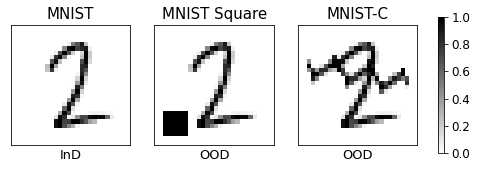

In [ ]:
#@markdown Check datasets
n = 456
title=15
subtitle=13
fig, axes = plt.subplots(1,3, figsize=(9,2.5))
cmap='binary'
axes[0].imshow(test_loader.dataset[n][0].squeeze(), cmap=cmap)
axes[0].set_title(f'MNIST', fontsize=title)
axes[0].set_xlabel('InD', fontsize=subtitle)

axes[1].imshow(loader_mnist_sq.dataset[n][0].squeeze(), cmap=cmap)
axes[1].set_title(f'MNIST Square', fontsize=title)
axes[1].set_xlabel('OOD', fontsize=subtitle)

im = axes[2].imshow(loader_mnist_c.dataset[n][0].squeeze(), cmap=cmap)
axes[2].set_title(f'MNIST-C', fontsize=title)
axes[2].set_xlabel('OOD', fontsize=subtitle)

for ax in axes.flatten():
  ax.set_xticks([])
  ax.set_yticks([])
cbar = plt.colorbar(im, ax=axes.ravel().tolist(), pad=0.04)
cbar.ax.tick_params(labelsize=12)
fig.savefig(figures_path / f'attribution_datasets.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@markdown Distances, reconst and agg counts
# Compute distances per class an closest clusters per class
distances_test_per_class, closest_clusters_per_cls_test = distance_to_clusters_averages(spk_count_test, preds_test, agg_counts_per_class_cluster)
distances_mnist_sq_per_class, closest_clusters_per_cls_mnist_sq = distance_to_clusters_averages(spk_count_mnist_sq, preds_mnist_sq, agg_counts_per_class_cluster)
distances_mnist_c_per_class, closest_clusters_per_cls_mnist_c = distance_to_clusters_averages(spk_count_mnist_c, preds_mnist_c, agg_counts_per_class_cluster)

# Create the reconstruction
if selected_model == 'ConvNet':
  weights = model.snn.state_dict()['fc1.weight'].cpu().numpy()
elif selected_model == 'Fully_connected':
  weights = model.state_dict()['snn.fc1.weight'].cpu().numpy()
else:
  raise NameError

reconst_test = np.dot(spk_count_test, weights)
reconst_mnist_sq = np.dot(spk_count_mnist_sq, weights)
reconst_mnist_c = np.dot(spk_count_mnist_c, weights)

# Extract negative part
reconst_test_neg      = np.where(reconst_test <= 0, -reconst_test, 0)
reconst_mnist_sq_neg  = np.where(reconst_mnist_sq <= 0, -reconst_mnist_sq, 0)
reconst_mnist_c_neg   = np.where(reconst_mnist_c <= 0, -reconst_mnist_c, 0)

# Extract positive part
reconst_test = np.where(reconst_test >= 0, reconst_test, 0)
reconst_mnist_sq = np.where(reconst_mnist_sq >= 0, reconst_mnist_sq, 0)
reconst_mnist_c = np.where(reconst_mnist_c >= 0, reconst_mnist_c, 0)


### Backprop the hidden counts of the median ###
agg_counts_reconstructed_per_class_and_cluster = compute_reconstruction_per_class(agg_counts_per_class_cluster, weights)
# Extract the positive part
avg_frecs_reconst_per_cl_clu_positive = extract_positive_part_per_class(agg_counts_reconstructed_per_class_and_cluster)
#avg_frecs_reconst_per_cl_clu_negative = extract_negative_part_per_class(agg_counts_reconstructed_per_class_and_cluster)

if selected_model == 'ConvNet':
  # Rearrange
  reconst_test = rearrange_to_ftmaps(reconst_test, ftmaps_shape=(50, 11, 11))
  reconst_mnist_sq = rearrange_to_ftmaps(reconst_mnist_sq, ftmaps_shape=(50, 11, 11))
  reconst_mnist_c = rearrange_to_ftmaps(reconst_mnist_c, ftmaps_shape=(50, 11, 11))
  avg_frecs_reconst_per_cl_clu_positive = rearrange_to_ftmaps_per_class(avg_frecs_reconst_per_cl_clu_positive, (50,11,11))

In [ ]:
#@markdown AUROC and AUPR and extrac distance threshodls
thresholds = auroc_aupr(distances_train_per_class, distances_test_per_class, distances_mnist_sq_per_class)

# For both OOD datasets, the thresholds are the same as they are based on the 
# In-Distribution training set 
_ = auroc_aupr(distances_train_per_class, distances_test_per_class, distances_mnist_c_per_class)

------------------------------
Results
------------------------------
AUROC = 72.048 %
AUPR  = 71.099 %
------------------------------
FPR at 95% TPR: 81.52%
Threshold mean and std for all classes at 95% TPR: 1950.40, 140.82
------------------------------ 

------------------------------
Results
------------------------------
AUROC = 70.926 %
AUPR  = 69.110 %
------------------------------
FPR at 95% TPR: 80.19%
Threshold mean and std for all classes at 95% TPR: 1950.40, 140.82
------------------------------ 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#@markdown ## Indices selection
indices = np.random.randint(0, 10000, 3)
print(indices)

[3714 8210 6522]


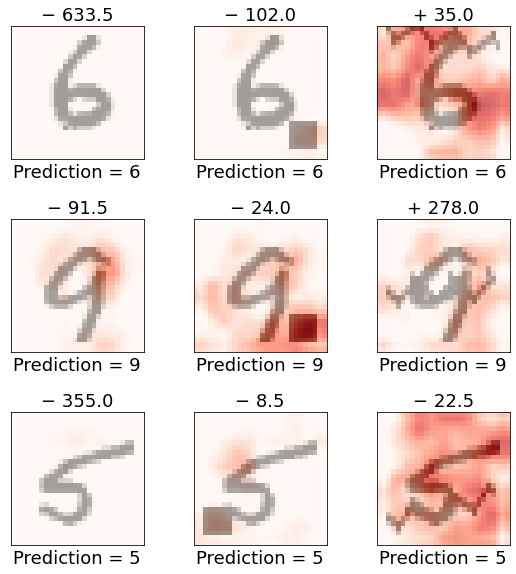

In [ ]:
#@markdown Plot with xlabel
nrows = len(indices)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
for i, ax_row in enumerate(axes):
    
  for j, ax in enumerate(ax_row):

    if j == 0:
      image = test_loader.dataset[indices[i]][0].squeeze()
      prediction = preds_test[indices[i]]
      # Obtain the index of the represented number in the per class order to extract the closest cluster (as it is in per class order)
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_test) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_test[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_test[prediction][i_in_per_cls_order]])

      dist = distances_test_per_class[prediction][i_in_per_cls_order]

    elif j == 1:
      image = loader_mnist_sq.dataset[indices[i]][0].squeeze()
      prediction = preds_mnist_sq[indices[i]]
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_mnist_sq) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_mnist_sq[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_mnist_sq[prediction][i_in_per_cls_order]])
      
      dist = distances_mnist_sq_per_class[prediction][i_in_per_cls_order]

    elif j == 2:
      image = loader_mnist_c.dataset[indices[i]][0].squeeze()
      prediction = preds_mnist_c[indices[i]]
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_mnist_c) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_mnist_c[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_mnist_c[prediction][i_in_per_cls_order]])
      dist = distances_mnist_c_per_class[prediction][i_in_per_cls_order]

    else:
      raise IndexError

    if selected_model == 'ConvNet':
      diff = resize(np.sum(diff, axis=0), (28, 28))
    plot_ax(ax, img=image, plt_range=[0,1], cmap='binary')

    which_fpr = 80 # To select the FPR (80 or 95)
    if dist - thresholds[prediction, which_fpr] >= 0:
      distance_to_centroid = '+ ' + str(dist - thresholds[prediction, which_fpr])
    else:
      distance_to_centroid = '\N{MINUS SIGN} ' + str(abs(dist - thresholds[prediction, which_fpr]))

    if selected_model == 'ConvNet':
      plot_ax(ax, img=diff.reshape(28,28), plt_range=plot_range, cmap='Reds', alpha=0.65, title=f'{distance_to_centroid}',xlabel=f'Prediction = {prediction}', fontsize=18)
    elif selected_model == 'Fully_connected':
      plot_ax(ax, img=diff.reshape(28,28), plt_range=plot_range, cmap='Reds', alpha=0.65, title=f'{distance_to_centroid}',xlabel=f'Prediction = {prediction}', fontsize=18)
    else:
      raise NameError 
      
    #plot_ax(ax, img=diff.reshape(28,28), plt_range=[200,1000], cmap='Reds', alpha=0.65, title=f'{distance_to_centroid}',xlabel=f'Prediction = {prediction}', fontsize=18)
    #plot_ax(ax, img=diff.reshape(28,28), plt_range=[200,1000], cmap='Reds', alpha=0.65, title=f'{prediction} | {dist}', fontsize=18)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.45)
fig.savefig(figures_path / f'{selected_model}_reconstruction.pdf', bbox_inches='tight')
#fig.savefig(figures_path / f'{selected_model}_reconstruction.png', dpi=300, bbox_inches='tight')

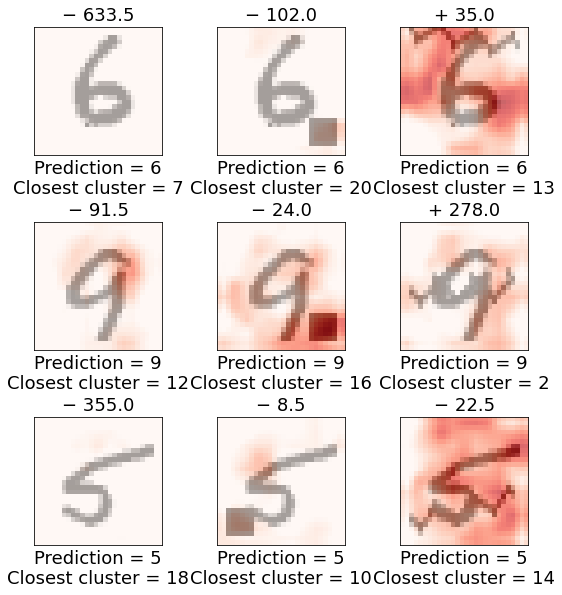

In [ ]:
#@markdown Plot with closest cluster also
nrows = len(indices)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
for i, ax_row in enumerate(axes):
    
  for j, ax in enumerate(ax_row):

    if j == 0:
      image = test_loader.dataset[indices[i]][0].squeeze()
      prediction = preds_test[indices[i]]
      # Obtain the index of the represented number in the per class order to extract the closest cluster (as it is in per class order)
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_test) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_test[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_test[prediction][i_in_per_cls_order]])
      dist = distances_test_per_class[prediction][i_in_per_cls_order]
      clu = [closest_clusters_per_cls_test[prediction][i_in_per_cls_order]]

    elif j == 1:
      image = loader_mnist_sq.dataset[indices[i]][0].squeeze()
      prediction = preds_mnist_sq[indices[i]]
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_mnist_sq) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_mnist_sq[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_mnist_sq[prediction][i_in_per_cls_order]])
      dist = distances_mnist_sq_per_class[prediction][i_in_per_cls_order]
      clu = [closest_clusters_per_cls_mnist_sq[prediction][i_in_per_cls_order]]

    elif j == 2:
      image = loader_mnist_c.dataset[indices[i]][0].squeeze()
      prediction = preds_mnist_c[indices[i]]
      i_in_per_cls_order = np.where(searchIndicesOfClass(prediction, preds_mnist_c) == np.array(indices[i]))[0][0]
      diff = np.abs(reconst_mnist_c[indices[i]] - avg_frecs_reconst_per_cl_clu_positive[prediction][closest_clusters_per_cls_mnist_c[prediction][i_in_per_cls_order]])
      dist = distances_mnist_c_per_class[prediction][i_in_per_cls_order]
      clu = [closest_clusters_per_cls_mnist_c[prediction][i_in_per_cls_order]]

    else:
      raise IndexError

    if selected_model == 'ConvNet':
      diff = resize(np.sum(diff, axis=0), (28, 28))
    plot_ax(ax, img=image, plt_range=[0,1], cmap='binary')

    which_fpr = 80 # To select the FPR (80 or 95)
    if dist - thresholds[prediction, which_fpr] >= 0:
      distance_to_centroid = '+ ' + str(dist - thresholds[prediction, which_fpr])
    else:
      distance_to_centroid = '\N{MINUS SIGN} ' + str(abs(dist - thresholds[prediction, which_fpr]))
    plot_ax(ax, img=diff.reshape(28,28), plt_range=plot_range, cmap='Reds', alpha=0.65, title=f'{distance_to_centroid}',xlabel=f'Prediction = {prediction}\nClosest cluster = {clu[0]}', fontsize=18)
    #plot_ax(ax, img=diff.reshape(28,28), plt_range=[200,1000], cmap='Reds', alpha=0.65, title=f'{prediction} | {dist}', fontsize=18)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.52)
fig.savefig(figures_path / f'{selected_model}_reconstruction.pdf', bbox_inches='tight')
#fig.savefig(figures_path / f'{selected_model}_reconstruction.png', dpi=300, bbox_inches='tight')